Dans ce notebook ensemble voting sur lr, randomforest et lgbm optimisés précédament

    * chargement du pipeline avec les 3 modèles et l'estimateur final

    * optimisation des poids de l'estimateur final
    
    * évaluation de l'ensemble
    
    * enregistrement pour dashboard




WORK IN PROGRESS

finaliser le score sut test dans funstions.py

changer lea affichages de scores par mean +- std

recuperer les scores depuis run à la fin pour faire un tableau de scores identique à celui de voting mais dans les 3 autres notebooks

# Imports

In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 
pd.set_option('display.max_row', 244)
pd.set_option('display.max_column', 243)
pd.set_option('display.max_colwidth', 50)

# graphical libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as py
import plotly.graph_objs as go


# misc libaries
import missingno as msno
bleu = (70 / 255, 130 / 255, 180 / 255)
# import dataprep.eda as eda
import qgrid

# File system manangement
import os
import joblib 

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 1
%aimport Functions
from Functions import *

Loading functions ...


.... done.


In [3]:
# CONSTANTS

ITERATIONS = 300

JOBS = 1

EDA = 'EDA 1-7 all features_aggregated'


LOG = True

RESUME = True
ID_RUN = 'PROJ-32'

# Log experiment to Neptune.ai

In [4]:
import neptune.new as neptune
# import neptunecontrib.monitoring.optuna as opt_utils
import neptune.new.integrations.optuna as optuna_utils
from neptune.new.types import File

if LOG:
    NEPTUNE_API_TOKEN="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkOTQ1YmNhNS1hZDYyLTRlYzQtYWU0Zi0xMjY0Yjg1MzBiMzEifQ=="
    # log to Neptune
    if RESUME:
        run = neptune.init(api_token=NEPTUNE_API_TOKEN,
                           project='m.leroy975/Projet07',
                           run=ID_RUN) # your credentials
    else:
        run = neptune.init(api_token=NEPTUNE_API_TOKEN,
                           project='m.leroy975/Projet07') # your credentials
        

    neptune_callback = optuna_utils.NeptuneCallback(run,
                                                    plots_update_freq=10,
                                                    log_plot_param_importances=True)

Info (NVML): NVML Shared Library Not Found. GPU usage metrics may not be reported. For more information, see https://docs-legacy.neptune.ai/logging-and-managing-experiment-results/logging-experiment-data.html#hardware-consumption 


https://app.neptune.ai/m.leroy975/Projet07/e/PROJ-32
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


# Chargement des données




In [5]:
# local run
path='FEATURES/'
features = joblib.load ( path+EDA+'.feat')

# Kaggle run
# path='../input/projet-07/' 
# features = joblib.load ( path+EDA+'.feat')

if LOG:
    # Name and hash of experiment features
    run['Data/Version/Features'].log(EDA)
    run['Data/Version/Features hash'].log(pd.util.hash_pandas_object(features))

Vérification du chargement

<AxesSubplot:>

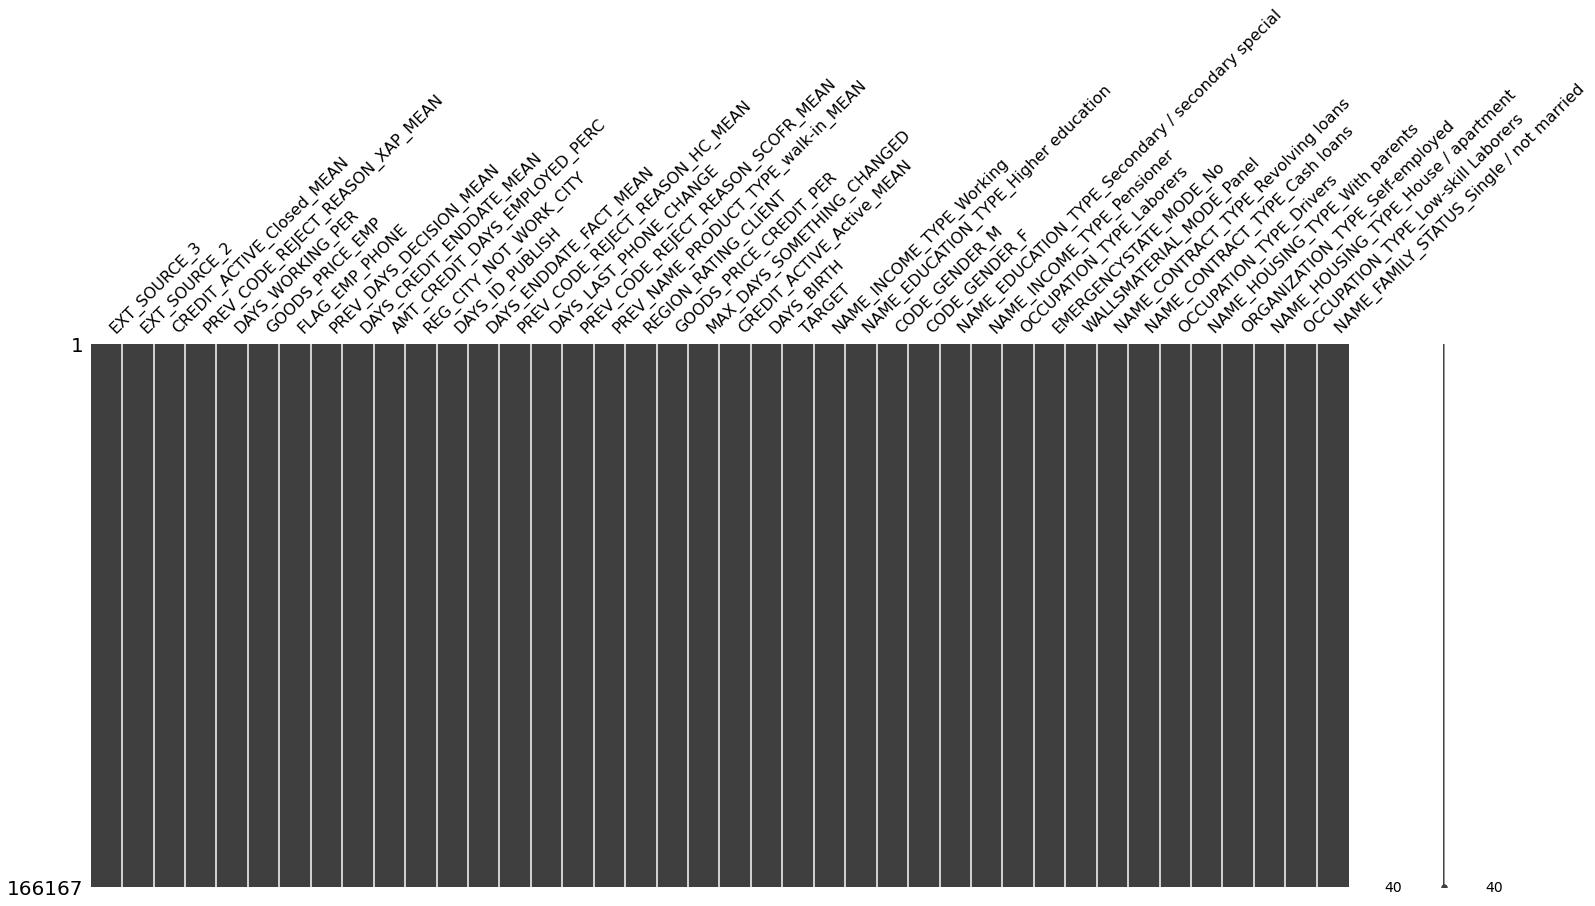

In [6]:
msno.matrix(features)

In [7]:
# Features overwiew
from collections import Counter

display(features)
print('Features shape {} x {}'.format(features.shape[0],features.shape[1]))
# TARGET ration on whole dataset
print('TARGET ratio {:.8%}'.format(features.TARGET.value_counts()[1]/features.TARGET.value_counts()[0]) )
print(Counter(features.TARGET))

,EXT_SOURCE_3,EXT_SOURCE_2,CREDIT_ACTIVE_Closed_MEAN,PREV_CODE_REJECT_REASON_XAP_MEAN,DAYS_WORKING_PER,GOODS_PRICE_EMP,FLAG_EMP_PHONE,PREV_DAYS_DECISION_MEAN,DAYS_CREDIT_ENDDATE_MEAN,AMT_CREDIT_DAYS_EMPLOYED_PERC,REG_CITY_NOT_WORK_CITY,DAYS_ID_PUBLISH,DAYS_ENDDATE_FACT_MEAN,PREV_CODE_REJECT_REASON_HC_MEAN,DAYS_LAST_PHONE_CHANGE,PREV_CODE_REJECT_REASON_SCOFR_MEAN,PREV_NAME_PRODUCT_TYPE_walk-in_MEAN,REGION_RATING_CLIENT,GOODS_PRICE_CREDIT_PER,MAX_DAYS_SOMETHING_CHANGED,CREDIT_ACTIVE_Active_MEAN,DAYS_BIRTH,TARGET,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,CODE_GENDER_M,CODE_GENDER_F,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_INCOME_TYPE_Pensioner,OCCUPATION_TYPE_Laborers,EMERGENCYSTATE_MODE_No,WALLSMATERIAL_MODE_Panel,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_TYPE_Cash loans,OCCUPATION_TYPE_Drivers,NAME_HOUSING_TYPE_With parents,ORGANIZATION_TYPE_Self-employed,NAME_HOUSING_TYPE_House / apartment,OCCUPATION_TYPE_Low-skill Laborers,NAME_FAMILY_STATUS_Single / not married
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100002,0.139376,0.262949,0.750000,1.00,0.067329,0.001815,1,-606.000000,-349.000000,-0.001567,0,-2120,-697.500000,0.00,-1134.0,0.0,0.00,2,1.158397,-637.0,0.250000,-9461,1,1,0,1,0,1,0,1,1,0,0,1,0,0,0,1,0,1
100004,0.729567,0.555912,1.000000,1.00,0.011814,0.001667,1,-815.000000,-488.500000,-0.001667,0,-2531,-532.500000,0.00,-815.0,0.0,0.00,2,1.000000,-225.0,0.000000,-19046,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,1
100008,0.621226,0.354225,0.666667,1.00,0.093737,0.003494,1,-1192.000000,-391.333333,-0.003238,0,-477,-909.000000,0.00,-2536.0,0.0,0.00,2,1.079198,-477.0,0.333333,-16941,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0
100009,0.492060,0.724000,0.777778,1.00,0.227174,0.002244,1,-719.285714,-794.937500,-0.002005,0,-619,-1108.500000,0.00,-1562.0,0.0,0.00,2,1.118800,-619.0,0.222222,-13778,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0
100010,0.540654,0.714279,0.500000,1.00,0.023820,0.000293,1,-1070.000000,-119.500000,-0.000293,1,-2379,-1138.000000,0.00,-1070.0,0.0,0.00,3,1.000000,-449.0,0.500000,-18850,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456246,0.735221,0.313334,0.666667,1.00,0.543859,0.038827,1,-897.000000,-234.666667,-0.038827,1,-4531,-1331.000000,0.00,-1516.0,0.0,0.00,2,1.000000,-4531.0,0.333333,-16063,0,1,0,0,1,1,0,1,0,0,0,1,0,0,0,1,0,0
456247,0.609276,0.501221,0.727273,0.80,0.033614,0.001612,1,-1387.800000,1449.818182,-0.001155,0,-3936,-1085.000000,0.20,-2315.0,0.0,0.00,2,1.396000,-399.0,0.272727,-11870,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1
456253,0.218859,0.535722,0.500000,1.00,0.529266,0.013540,1,-2380.000000,280.500000,-0.011689,1,-5150,-794.000000,0.00,-1909.0,0.0,0.00,3,1.158400,-5150.0,0.500000,-14966,0,1,1,0,1,0,0,0,1,1,0,1,0,0,0,1,0,0


Features shape 166167 x 40
TARGET ratio 8.55196112%
Counter({0: 153076, 1: 13091})


In [8]:
# Descriptive Statistics of features
features.describe()

,EXT_SOURCE_3,EXT_SOURCE_2,CREDIT_ACTIVE_Closed_MEAN,PREV_CODE_REJECT_REASON_XAP_MEAN,DAYS_WORKING_PER,GOODS_PRICE_EMP,FLAG_EMP_PHONE,PREV_DAYS_DECISION_MEAN,DAYS_CREDIT_ENDDATE_MEAN,AMT_CREDIT_DAYS_EMPLOYED_PERC,REG_CITY_NOT_WORK_CITY,DAYS_ID_PUBLISH,DAYS_ENDDATE_FACT_MEAN,PREV_CODE_REJECT_REASON_HC_MEAN,DAYS_LAST_PHONE_CHANGE,PREV_CODE_REJECT_REASON_SCOFR_MEAN,PREV_NAME_PRODUCT_TYPE_walk-in_MEAN,REGION_RATING_CLIENT,GOODS_PRICE_CREDIT_PER,MAX_DAYS_SOMETHING_CHANGED,CREDIT_ACTIVE_Active_MEAN,DAYS_BIRTH,TARGET,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,CODE_GENDER_M,CODE_GENDER_F,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_INCOME_TYPE_Pensioner,OCCUPATION_TYPE_Laborers,EMERGENCYSTATE_MODE_No,WALLSMATERIAL_MODE_Panel,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_TYPE_Cash loans,OCCUPATION_TYPE_Drivers,NAME_HOUSING_TYPE_With parents,ORGANIZATION_TYPE_Self-employed,NAME_HOUSING_TYPE_House / apartment,OCCUPATION_TYPE_Low-skill Laborers,NAME_FAMILY_STATUS_Single / not married
count,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000,166167.000000
mean,0.510254,0.522642,0.653379,0.862457,0.167316,0.007263,0.999958,-960.521684,530.334778,-0.006516,0.269277,-2930.144674,-948.376072,0.061706,-1068.932953,0.005888,0.081658,2.055155,1.121982,-1432.258649,0.342891,-15032.894594,0.078782,0.634380,0.268224,0.363875,0.636101,0.687832,0.000048,0.217281,0.525772,0.217841,0.093159,0.906841,0.072523,0.052080,0.142922,0.883238,0.006933,0.136549
std,0.194889,0.186316,0.224893,0.197724,0.138021,0.011067,0.006490,568.583412,2591.803993,0.009935,0.443586,1485.687941,512.259742,0.133164,825.083618,0.043194,0.177446,0.499675,0.124831,1181.062229,0.223960,3555.439786,0.269399,0.481605,0.443036,0.481115,0.481122,0.463379,0.006938,0.412397,0.499337,0.412780,0.290656,0.290656,0.259353,0.222189,0.349995,0.321138,0.082974,0.343372
min,0.000527,0.000010,0.000000,0.000000,0.000042,0.000002,0.000000,-2922.000000,-28039.000000,-0.256178,0.000000,-7197.000000,-2884.000000,0.000000,-4173.000000,0.000000,0.000000,1.000000,0.150000,-6226.000000,0.000000,-25200.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.370650,0.411550,0.500000,0.750000,0.061777,0.001720,1.000000,-1297.000000,-711.000000,-0.007465,0.000000,-4239.000000,-1269.500000,0.000000,-1684.000000,0.000000,0.000000,2.000000,1.000000,-2094.000000,0.187500,-17721.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,0.537070,0.573477,0.666667,1.000000,0.130267,0.003899,1.000000,-845.333333,-197.000000,-0.003506,0.000000,-3076.000000,-916.000000,0.000000,-929.000000,0.000000,0.000000,2.000000,1.118800,-1094.000000,0.333333,-14834.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.667458,0.666053,0.800000,1.000000,0.234369,0.008310,1.000000,-512.464286,505.950000,-0.001541,1.000000,-1696.000000,-565.633333,0.000000,-376.000000,0.000000,0.083333,2.000000,1.198000,-495.000000,0.500000,-12168.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,0.885488,0.855000,1.000000,1.000000,0.728811,0.256178,1.000000,-2.000000

# SPLITTING

In [9]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(features,
                               test_size=.20,
                               random_state=42,
                               shuffle=True,
                               stratify=features.TARGET)

train_true = train.pop('TARGET')
print('train',train.shape)
print('TARGET=1 ratio on train {:.8%}'.format(train_true.value_counts()[1]/train_true.value_counts()[0]) )
test_true = test.pop('TARGET')
print('test',test.shape)
print('TARGET=1 ratio on test {:.8%}'.format(test_true.value_counts()[1]/test_true.value_counts()[0]))

train (132933, 39)
TARGET=1 ratio on train 8.55218030%
test (33234, 39)
TARGET=1 ratio on test 8.55108440%


In [10]:
if LOG:
    run['Data/Version/Train shape'].log(str(train.shape))
    run['Data/Version/Train target ratio'].log(train_true.value_counts()[1]/train_true.value_counts()[0])
    run['Data/Version/Test shape'].log(str(test.shape))
    run['Data/Version/Test target ratio'].log(test_true.value_counts()[1]/test_true.value_counts()[0])

# Chargement du modèle voting

In [11]:
voting = joblib.load ('Models/voting_classifier.mod')
display(voting.get_params(deep=False))
if LOG:
    # Name and hash of experiment features
    run['Modele/Name'] = 'Voting Classifier'

{'estimators': [('lr',
   Pipeline(steps=[('over',
                    RandomOverSampler(random_state=42,
                                      sampling_strategy=0.12496086406604352)),
                   ('under',
                    RandomUnderSampler(random_state=42,
                                       sampling_strategy=0.24875095137776715)),
                   ('scaler', RobustScaler(unit_variance=True)),
                   ('model',
                    LogisticRegression(C=387.7896540335958,
                                       class_weight='balanced', max_iter=1000,
                                       n_jobs=-1, random_state=42,
                                       tol=2.4770441141413036e-05))])),
  ('rf',
   Pipeline(steps=[('over',
                    RandomOverSampler(random_state=42,
                                      sampling_strategy=0.12355964682885018)),
                   ('under',
                    RandomUnderSampler(random_state=42,
                      

###  Metrics¶

In [12]:
from sklearn.metrics import  confusion_matrix, make_scorer, roc_auc_score

# Cost weight
tn_cost = 2  ; fn_cost = -5
fp_cost = -6  ; tp_cost = 1

penalty = np.array([tn_cost,fn_cost,fp_cost,tp_cost])

# cost function
def cost(y,y_pred):
    cm = confusion_matrix(y,y_pred,normalize='true')
    return  (sum( cm.reshape(-1)*penalty)+11)/14

SCORER = {'AUC' : 'roc_auc', 'COST' : make_scorer(cost)}

## Optimisation des poids

In [13]:
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_score
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

## Recherche de la combinaison optimale

In [14]:
### fonction to maximize
from sklearn.model_selection import cross_validate
from sklearn.base import clone

def Opt_search(trial):
    # the function gets a set of variable parameters in "param"
    # we use theses params to set pipeline params
    
    # Initialize params
    params = {}
    trial_voting = clone(voting)
    
    # Logistic regression weight
    lr_weight = trial.suggest_float('lr_weight', 0, 1)  # MODIFIE
    
    # Random Forest weight
    rf_weight = trial.suggest_float('rf_weight', 0, 1)  # MODIFIE
    
    # LGBM weight
    lgbm_weight = trial.suggest_float('lgbm_weight', 0, 1)  # MODIFIE
    
    params['weights'] = [lr_weight, rf_weight, lgbm_weight]
#     print('> params >>',params)
    
    # we use theses params to set pipeline params
    trial_voting.set_params(**params)
    
#     print('> get params>>',trial_voting.get_params(deep=False))
               
    # score
    score = cross_validate(trial_voting,
                           train,
                           train_true,
                           scoring=SCORER,
                           n_jobs=1,
                           cv=cv)
    
    print('> cv cost score mean: %.4f (\u00B1 %.4f) <> roc auc score mean: %.4f (\u00B1 %.4f) < ' % (
                                                                                        score['test_COST'].mean(),
                                                                                        score['test_COST'].std(),
                                                                                        score['test_AUC'].mean(),
                                                                                        score['test_AUC'].std()
                                                                                       )
         )
    
    if LOG:
        run['AUC'].log(score['test_AUC'].mean())
        run['COST'].log(score['test_COST'].mean())
        
    return score['test_COST'].mean()

In [15]:
# Create study the first time or append existing
import os.path
from os import path
import optuna
from optuna.samplers import TPESampler


# Studiing n_iter times
n_iter = ITERATIONS

# Optimize
if LOG and RESUME:
    # Load Optuna Study from the Neptune Run
    study = optuna_utils.load_study_from_run(run)  
    study.optimize(Opt_search, n_trials=n_iter, n_jobs=JOBS, callbacks=[neptune_callback])
elif LOG and not RESUME:
    name = 'Voting classifier '+EDA
    study = optuna.create_study(study_name=name,
                                    direction='maximize',

                                    sampler=TPESampler(n_startup_trials= 50)
                                   )
    study.optimize(Opt_search, n_trials=n_iter, n_jobs=JOBS, callbacks=[neptune_callback])
    
else:
    # Local run
    save_path = 'Studies/'
    name =save_path+'voting_'+EDA
    file_name = name+'.study'

    if path.exists(file_name):
        # load study
        study = joblib.load(file_name)
        print('Loading {}'.format(file_name))

        # Load Optuna Study from the Neptune Run
    #     study = optuna_utils.load_study_from_run(run)

    else:
        # Otherwise create study
        print('Creating a new study named {}'.format(name))
        study = optuna.create_study(study_name=name,
                                    direction='maximize',

                                    sampler=TPESampler(n_startup_trials= 2)
                                   )
        
    study.optimize(Opt_search, n_trials=n_iter, n_jobs=JOBS)

# # save the sutdy 
# joblib.dump(study, file_name)

# print best results
print('Best custom_score = {} for :\n'.format(study.best_value))

for key, value in study.best_params.items():
    print("    {}: {}".format(key, value))

[I 2021-07-28 23:21:44,815] Trial 300 finished with value: 0.6830611559505352 and parameters: {'lr_weight': 0.8582960295128442, 'rf_weight': 0.12539560926268004, 'lgbm_weight': 0.5318510826600423}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6831 (± 0.0055) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-28 23:23:22,900] Trial 301 finished with value: 0.6830925741510422 and parameters: {'lr_weight': 0.6381464084919788, 'rf_weight': 0.1733736366311725, 'lgbm_weight': 0.4559151735505066}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6831 (± 0.0053) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-28 23:24:35,359] Trial 302 finished with value: 0.6829990394622534 and parameters: {'lr_weight': 0.7828848571291066, 'rf_weight': 0.02950958366794819, 'lgbm_weight': 0.38436811766343043}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6830 (± 0.0055) <> roc auc score mean: 0.7459 (± 0.0061) < 


[I 2021-07-28 23:25:47,802] Trial 303 finished with value: 0.682985154145016 and parameters: {'lr_weight': 0.6096067368148498, 'rf_weight': 0.15737676330701478, 'lgbm_weight': 0.4011350393666884}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6830 (± 0.0052) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-28 23:26:59,278] Trial 304 finished with value: 0.6829025718095247 and parameters: {'lr_weight': 0.8161079697975232, 'rf_weight': 0.06508464682158865, 'lgbm_weight': 0.5711807373439531}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6829 (± 0.0055) <> roc auc score mean: 0.7461 (± 0.0061) < 


[I 2021-07-28 23:28:10,635] Trial 305 finished with value: 0.6829820853772496 and parameters: {'lr_weight': 0.6470638620603254, 'rf_weight': 0.220037630341043, 'lgbm_weight': 0.4261986036374278}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6830 (± 0.0051) <> roc auc score mean: 0.7461 (± 0.0059) < 


[I 2021-07-28 23:29:21,364] Trial 306 finished with value: 0.6825422913493316 and parameters: {'lr_weight': 0.5466686291322327, 'rf_weight': 0.10764318285804567, 'lgbm_weight': 0.4473007755708581}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6825 (± 0.0055) <> roc auc score mean: 0.7462 (± 0.0060) < 


[I 2021-07-28 23:30:32,753] Trial 307 finished with value: 0.6829179176977836 and parameters: {'lr_weight': 0.7031551929653967, 'rf_weight': 0.08297470455268086, 'lgbm_weight': 0.3501935610228809}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6829 (± 0.0056) <> roc auc score mean: 0.7460 (± 0.0060) < 


[I 2021-07-28 23:31:43,088] Trial 308 finished with value: 0.6833001994724177 and parameters: {'lr_weight': 0.592086910950149, 'rf_weight': 0.13853148314025937, 'lgbm_weight': 0.40399028012484395}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6833 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-28 23:32:53,771] Trial 309 finished with value: 0.6818025839210216 and parameters: {'lr_weight': 0.5663323680294023, 'rf_weight': 0.13201170630587036, 'lgbm_weight': 0.6272536013083969}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6818 (± 0.0059) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-28 23:34:04,227] Trial 310 finished with value: 0.6822424463338921 and parameters: {'lr_weight': 0.5954498655393248, 'rf_weight': 0.4773594145667822, 'lgbm_weight': 0.37929800202953373}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6822 (± 0.0049) <> roc auc score mean: 0.7459 (± 0.0057) < 


[I 2021-07-28 23:35:41,423] Trial 311 finished with value: 0.6827307527957084 and parameters: {'lr_weight': 0.842527297646204, 'rf_weight': 0.1510814878891379, 'lgbm_weight': 0.4018888836445209}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6827 (± 0.0055) <> roc auc score mean: 0.7459 (± 0.0060) < 


[I 2021-07-28 23:36:53,122] Trial 312 finished with value: 0.6827395821943868 and parameters: {'lr_weight': 0.585122501926289, 'rf_weight': 0.19883712941810255, 'lgbm_weight': 0.46504791697278325}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6827 (± 0.0053) <> roc auc score mean: 0.7462 (± 0.0059) < 


[I 2021-07-28 23:38:05,306] Trial 313 finished with value: 0.6819684565655699 and parameters: {'lr_weight': 0.5248948819733855, 'rf_weight': 0.1350459142512718, 'lgbm_weight': 0.5036140508684711}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6820 (± 0.0057) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-28 23:39:15,866] Trial 314 finished with value: 0.681778194672835 and parameters: {'lr_weight': 0.735402261351493, 'rf_weight': 0.8371440674642836, 'lgbm_weight': 0.5525492609209338}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6818 (± 0.0049) <> roc auc score mean: 0.7457 (± 0.0056) < 


[I 2021-07-28 23:40:26,088] Trial 315 finished with value: 0.6828536272370054 and parameters: {'lr_weight': 0.8757119412069893, 'rf_weight': 0.17900605378608297, 'lgbm_weight': 0.40409195157795014}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6829 (± 0.0057) <> roc auc score mean: 0.7459 (± 0.0060) < 


[I 2021-07-28 23:41:37,537] Trial 316 finished with value: 0.6828910080905073 and parameters: {'lr_weight': 0.9091569171551861, 'rf_weight': 0.15666628187577705, 'lgbm_weight': 0.3703777848979336}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6829 (± 0.0053) <> roc auc score mean: 0.7458 (± 0.0060) < 


[I 2021-07-28 23:42:47,626] Trial 317 finished with value: 0.6827618821387563 and parameters: {'lr_weight': 0.6568099535425767, 'rf_weight': 0.1152673939042688, 'lgbm_weight': 0.33571229025837573}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6828 (± 0.0057) <> roc auc score mean: 0.7460 (± 0.0060) < 


[I 2021-07-28 23:43:58,730] Trial 318 finished with value: 0.6829839368414851 and parameters: {'lr_weight': 0.6182211029250895, 'rf_weight': 0.0971098362745125, 'lgbm_weight': 0.43991627384618925}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6830 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-28 23:45:09,934] Trial 319 finished with value: 0.6816320451677799 and parameters: {'lr_weight': 0.5630354922209344, 'rf_weight': 0.1805757503638912, 'lgbm_weight': 0.5991794066264607}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6816 (± 0.0058) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-28 23:46:20,904] Trial 320 finished with value: 0.6828111839536873 and parameters: {'lr_weight': 0.5997301869630765, 'rf_weight': 0.2126701197413281, 'lgbm_weight': 0.4153156833827356}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6828 (± 0.0052) <> roc auc score mean: 0.7461 (± 0.0059) < 


[I 2021-07-28 23:48:02,755] Trial 321 finished with value: 0.683046375838028 and parameters: {'lr_weight': 0.6729438648824706, 'rf_weight': 0.141044177574803, 'lgbm_weight': 0.4812457817930264}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6830 (± 0.0053) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-28 23:49:13,605] Trial 322 finished with value: 0.6830338380829699 and parameters: {'lr_weight': 0.6272625656842352, 'rf_weight': 0.09453438888080005, 'lgbm_weight': 0.39156883595000014}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6830 (± 0.0056) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-28 23:50:24,578] Trial 323 finished with value: 0.6813462777191909 and parameters: {'lr_weight': 0.7972476194371262, 'rf_weight': 0.23753310485586024, 'lgbm_weight': 0.9976412256232837}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6813 (± 0.0056) <> roc auc score mean: 0.7460 (± 0.0060) < 


[I 2021-07-28 23:51:37,422] Trial 324 finished with value: 0.6825206364214843 and parameters: {'lr_weight': 0.64605928830968, 'rf_weight': 0.1163869338657314, 'lgbm_weight': 0.527750443054125}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6825 (± 0.0056) <> roc auc score mean: 0.7462 (± 0.0060) < 


[I 2021-07-28 23:52:48,146] Trial 325 finished with value: 0.6827926542393931 and parameters: {'lr_weight': 0.9472901457174259, 'rf_weight': 0.16402242789131785, 'lgbm_weight': 0.4172892811689779}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6828 (± 0.0056) <> roc auc score mean: 0.7459 (± 0.0060) < 


[I 2021-07-28 23:53:58,578] Trial 326 finished with value: 0.682619664595362 and parameters: {'lr_weight': 0.5859122893134198, 'rf_weight': 0.04900233878377315, 'lgbm_weight': 0.5760761435016495}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6826 (± 0.0061) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-28 23:55:10,368] Trial 327 finished with value: 0.6828434784990411 and parameters: {'lr_weight': 0.8193427814807384, 'rf_weight': 0.08447236219532438, 'lgbm_weight': 0.35979842184088356}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6828 (± 0.0055) <> roc auc score mean: 0.7458 (± 0.0061) < 


[I 2021-07-28 23:56:22,036] Trial 328 finished with value: 0.6827172301487918 and parameters: {'lr_weight': 0.6254311075347406, 'rf_weight': 0.19791297138893293, 'lgbm_weight': 0.44302448176231257}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6827 (± 0.0053) <> roc auc score mean: 0.7461 (± 0.0059) < 


[I 2021-07-28 23:57:33,313] Trial 329 finished with value: 0.6829126347954615 and parameters: {'lr_weight': 0.6712757785030579, 'rf_weight': 0.1294711792579475, 'lgbm_weight': 0.3832359745103543}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6829 (± 0.0056) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-28 23:58:43,514] Trial 330 finished with value: 0.6825775492482145 and parameters: {'lr_weight': 0.5972556130368076, 'rf_weight': 0.06881801709477142, 'lgbm_weight': 0.5524353152882251}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6826 (± 0.0059) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 00:00:26,742] Trial 331 finished with value: 0.6831042681287076 and parameters: {'lr_weight': 0.8400248990685096, 'rf_weight': 0.10261933034470368, 'lgbm_weight': 0.461937332418332}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6831 (± 0.0054) <> roc auc score mean: 0.7460 (± 0.0060) < 


[I 2021-07-29 00:01:39,619] Trial 332 finished with value: 0.6828564190864791 and parameters: {'lr_weight': 0.708185781815259, 'rf_weight': 0.1449180464302594, 'lgbm_weight': 0.42856570298865254}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6829 (± 0.0056) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 00:02:51,453] Trial 333 finished with value: 0.682629659196346 and parameters: {'lr_weight': 0.5445505733206912, 'rf_weight': 0.04991052503891881, 'lgbm_weight': 0.4927295718683388}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6826 (± 0.0060) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 00:04:02,286] Trial 334 finished with value: 0.6827496332411573 and parameters: {'lr_weight': 0.6389830516806579, 'rf_weight': 0.02247052868861945, 'lgbm_weight': 0.3886050598002414}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6827 (± 0.0055) <> roc auc score mean: 0.7460 (± 0.0061) < 


[I 2021-07-29 00:05:13,965] Trial 335 finished with value: 0.682815277775372 and parameters: {'lr_weight': 0.8641256891092663, 'rf_weight': 0.17899547094285695, 'lgbm_weight': 0.4084296811623506}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6828 (± 0.0056) <> roc auc score mean: 0.7459 (± 0.0060) < 


[I 2021-07-29 00:06:27,081] Trial 336 finished with value: 0.6827907463293712 and parameters: {'lr_weight': 0.5698147581196948, 'rf_weight': 0.11756944772383272, 'lgbm_weight': 0.4484133755630178}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6828 (± 0.0058) <> roc auc score mean: 0.7462 (± 0.0060) < 


[I 2021-07-29 00:07:40,029] Trial 337 finished with value: 0.6828268870843578 and parameters: {'lr_weight': 0.7711319077926072, 'rf_weight': 0.08397603768394066, 'lgbm_weight': 0.5901682006068091}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6828 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 00:08:50,904] Trial 338 finished with value: 0.6827967089823662 and parameters: {'lr_weight': 0.609382147142961, 'rf_weight': 0.0018103433399191474, 'lgbm_weight': 0.4255721410989597}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6828 (± 0.0056) <> roc auc score mean: 0.7461 (± 0.0061) < 


[I 2021-07-29 00:10:02,515] Trial 339 finished with value: 0.6827248075097886 and parameters: {'lr_weight': 0.69256068406235, 'rf_weight': 0.2227557922728014, 'lgbm_weight': 0.5396968104602955}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6827 (± 0.0054) <> roc auc score mean: 0.7462 (± 0.0059) < 


[I 2021-07-29 00:11:14,288] Trial 340 finished with value: 0.6818277842618767 and parameters: {'lr_weight': 0.6601364334575506, 'rf_weight': 0.6246831206489839, 'lgbm_weight': 0.36989680229261857}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6818 (± 0.0047) <> roc auc score mean: 0.7456 (± 0.0057) < 


[I 2021-07-29 00:12:58,365] Trial 341 finished with value: 0.6830319974745525 and parameters: {'lr_weight': 0.896039937682142, 'rf_weight': 0.16327928817316528, 'lgbm_weight': 0.32294405326619685}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6830 (± 0.0053) <> roc auc score mean: 0.7457 (± 0.0060) < 


[I 2021-07-29 00:14:10,538] Trial 342 finished with value: 0.68325495240046 and parameters: {'lr_weight': 0.6345989289013787, 'rf_weight': 0.07067812829606201, 'lgbm_weight': 0.40005321630157326}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6833 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 00:15:22,772] Trial 343 finished with value: 0.6826026301862396 and parameters: {'lr_weight': 0.6406382710844607, 'rf_weight': 0.2577012553767686, 'lgbm_weight': 0.5159963272192029}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6826 (± 0.0055) <> roc auc score mean: 0.7461 (± 0.0059) < 


[I 2021-07-29 00:16:34,770] Trial 344 finished with value: 0.6824584862824001 and parameters: {'lr_weight': 0.6533236280588857, 'rf_weight': 0.10002836616727584, 'lgbm_weight': 0.6369007720582192}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6825 (± 0.0057) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 00:17:46,606] Trial 345 finished with value: 0.6828401100179977 and parameters: {'lr_weight': 0.67826219367502, 'rf_weight': 0.13053412519990187, 'lgbm_weight': 0.41016210434762473}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6828 (± 0.0056) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 00:18:58,601] Trial 346 finished with value: 0.6807955410672231 and parameters: {'lr_weight': 0.6348488284261811, 'rf_weight': 0.9992895763339952, 'lgbm_weight': 0.4357314503136885}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6808 (± 0.0044) <> roc auc score mean: 0.7452 (± 0.0055) < 


[I 2021-07-29 00:20:11,238] Trial 347 finished with value: 0.6828206127789197 and parameters: {'lr_weight': 0.620871227424294, 'rf_weight': 0.2032134872705051, 'lgbm_weight': 0.4538428049627731}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6828 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0059) < 


[I 2021-07-29 00:21:22,990] Trial 348 finished with value: 0.6825967011840468 and parameters: {'lr_weight': 0.666906379936224, 'rf_weight': 0.07511259059967705, 'lgbm_weight': 0.6136815300833551}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6826 (± 0.0058) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 00:22:36,263] Trial 349 finished with value: 0.6830668644802216 and parameters: {'lr_weight': 0.7199963218855114, 'rf_weight': 0.04064179654247381, 'lgbm_weight': 0.4731649307395595}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6831 (± 0.0055) <> roc auc score mean: 0.7461 (± 0.0061) < 


[I 2021-07-29 00:23:49,355] Trial 350 finished with value: 0.6830590102009318 and parameters: {'lr_weight': 0.8006116757625087, 'rf_weight': 0.11726456934833238, 'lgbm_weight': 0.5641272187956269}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6831 (± 0.0053) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 00:25:35,088] Trial 351 finished with value: 0.6829952399259368 and parameters: {'lr_weight': 0.691137155194026, 'rf_weight': 0.18723347026674345, 'lgbm_weight': 0.4000874667299827}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6830 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 00:26:48,087] Trial 352 finished with value: 0.6827979773037747 and parameters: {'lr_weight': 0.9375082918283185, 'rf_weight': 0.14256950315918068, 'lgbm_weight': 0.42223955039068073}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6828 (± 0.0057) <> roc auc score mean: 0.7459 (± 0.0060) < 


[I 2021-07-29 00:27:59,940] Trial 353 finished with value: 0.6826173581975213 and parameters: {'lr_weight': 0.8521096092973427, 'rf_weight': 0.08501306980877905, 'lgbm_weight': 0.356255221682255}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6826 (± 0.0056) <> roc auc score mean: 0.7458 (± 0.0061) < 


[I 2021-07-29 00:29:11,420] Trial 354 finished with value: 0.6829544102672728 and parameters: {'lr_weight': 0.7505841765647057, 'rf_weight': 0.1616305922837047, 'lgbm_weight': 0.46764844840786735}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6830 (± 0.0056) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 00:30:23,959] Trial 355 finished with value: 0.6828740138434441 and parameters: {'lr_weight': 0.8275577542236592, 'rf_weight': 0.05856401667953551, 'lgbm_weight': 0.5821662228019326}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6829 (± 0.0056) <> roc auc score mean: 0.7461 (± 0.0061) < 


[I 2021-07-29 00:31:35,301] Trial 356 finished with value: 0.6829970740230971 and parameters: {'lr_weight': 0.8845473078368177, 'rf_weight': 0.10470011162802562, 'lgbm_weight': 0.42908816860243504}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6830 (± 0.0056) <> roc auc score mean: 0.7459 (± 0.0060) < 


[I 2021-07-29 00:32:48,073] Trial 357 finished with value: 0.6831987594864618 and parameters: {'lr_weight': 0.6178917559371598, 'rf_weight': 0.09986811527127894, 'lgbm_weight': 0.3982166578122805}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6832 (± 0.0055) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 00:33:59,531] Trial 358 finished with value: 0.6831070827731655 and parameters: {'lr_weight': 0.6499004606472827, 'rf_weight': 0.0708541282010322, 'lgbm_weight': 0.4502293767610226}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6831 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 00:35:10,663] Trial 359 finished with value: 0.6827276047871713 and parameters: {'lr_weight': 0.5797804828049795, 'rf_weight': 0.1239242149794666, 'lgbm_weight': 0.4912361705496292}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6827 (± 0.0057) <> roc auc score mean: 0.7462 (± 0.0060) < 


[I 2021-07-29 00:36:22,599] Trial 360 finished with value: 0.6827754112969304 and parameters: {'lr_weight': 0.6314030235855123, 'rf_weight': 0.21492168102523262, 'lgbm_weight': 0.3714763521965781}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6828 (± 0.0053) <> roc auc score mean: 0.7461 (± 0.0059) < 


[I 2021-07-29 00:38:07,281] Trial 361 finished with value: 0.6829999060346301 and parameters: {'lr_weight': 0.6105063065994585, 'rf_weight': 0.17254195908809838, 'lgbm_weight': 0.41089085279266147}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6830 (± 0.0052) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 00:39:18,491] Trial 362 finished with value: 0.6830700070608496 and parameters: {'lr_weight': 0.9171225529093103, 'rf_weight': 0.032301129045050725, 'lgbm_weight': 0.4383810906174678}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6831 (± 0.0056) <> roc auc score mean: 0.7459 (± 0.0061) < 


[I 2021-07-29 00:40:30,313] Trial 363 finished with value: 0.6827414108636379 and parameters: {'lr_weight': 0.6619893379227876, 'rf_weight': 0.14240689086274896, 'lgbm_weight': 0.5421467671682183}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6827 (± 0.0056) <> roc auc score mean: 0.7462 (± 0.0060) < 


[I 2021-07-29 00:41:42,166] Trial 364 finished with value: 0.6829512503195696 and parameters: {'lr_weight': 0.5551837270286064, 'rf_weight': 0.08604378595783307, 'lgbm_weight': 0.3905519373958276}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6830 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 00:42:53,575] Trial 365 finished with value: 0.6831117488818588 and parameters: {'lr_weight': 0.6369831432091584, 'rf_weight': 0.19867580900993226, 'lgbm_weight': 0.4178988633634668}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6831 (± 0.0051) <> roc auc score mean: 0.7461 (± 0.0059) < 


[I 2021-07-29 00:44:05,205] Trial 366 finished with value: 0.6826092671619982 and parameters: {'lr_weight': 0.5209360384856908, 'rf_weight': 0.04975429508245298, 'lgbm_weight': 0.4634708943341082}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6826 (± 0.0060) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 00:45:18,850] Trial 367 finished with value: 0.6826296309734528 and parameters: {'lr_weight': 0.5950384497129464, 'rf_weight': 0.2368144455598512, 'lgbm_weight': 0.5147437571319576}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6826 (± 0.0053) <> roc auc score mean: 0.7461 (± 0.0059) < 


[I 2021-07-29 00:46:31,691] Trial 368 finished with value: 0.6832087996774142 and parameters: {'lr_weight': 0.9680292043098041, 'rf_weight': 0.09741863637138892, 'lgbm_weight': 0.6040228137119052}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6832 (± 0.0055) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 00:47:43,083] Trial 369 finished with value: 0.6827402619450595 and parameters: {'lr_weight': 0.6750874632876441, 'rf_weight': 0.11764845745222254, 'lgbm_weight': 0.5696894914085288}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6827 (± 0.0056) <> roc auc score mean: 0.7462 (± 0.0060) < 


[I 2021-07-29 00:48:55,484] Trial 370 finished with value: 0.6831142855246759 and parameters: {'lr_weight': 0.7812734116390201, 'rf_weight': 0.15560982063113296, 'lgbm_weight': 0.34315821523876183}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6831 (± 0.0056) <> roc auc score mean: 0.7459 (± 0.0060) < 


[I 2021-07-29 00:50:43,415] Trial 371 finished with value: 0.6830831333866436 and parameters: {'lr_weight': 0.862101252561831, 'rf_weight': 0.061466720441980316, 'lgbm_weight': 0.43531856350066217}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6831 (± 0.0054) <> roc auc score mean: 0.7459 (± 0.0061) < 


[I 2021-07-29 00:51:56,851] Trial 372 finished with value: 0.6831121115521793 and parameters: {'lr_weight': 0.6180035123751845, 'rf_weight': 0.18423975801089224, 'lgbm_weight': 0.3850256724448097}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6831 (± 0.0053) <> roc auc score mean: 0.7461 (± 0.0059) < 


[I 2021-07-29 00:53:08,184] Trial 373 finished with value: 0.6831513210749324 and parameters: {'lr_weight': 0.6519494575111854, 'rf_weight': 0.07658459458109394, 'lgbm_weight': 0.40635298240727835}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6832 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 00:54:19,475] Trial 374 finished with value: 0.6831211831350001 and parameters: {'lr_weight': 0.8162085011773401, 'rf_weight': 0.13489750268295192, 'lgbm_weight': 0.4964847930356294}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6831 (± 0.0056) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 00:55:31,918] Trial 375 finished with value: 0.6828900112594825 and parameters: {'lr_weight': 0.6939926762712045, 'rf_weight': 0.11031989065025322, 'lgbm_weight': 0.36824142501014245}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6829 (± 0.0058) <> roc auc score mean: 0.7460 (± 0.0060) < 


[I 2021-07-29 00:56:44,431] Trial 376 finished with value: 0.6827810916037236 and parameters: {'lr_weight': 0.49533551944013027, 'rf_weight': 0.08327070871694031, 'lgbm_weight': 0.4281488286536928}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6828 (± 0.0057) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 00:57:56,666] Trial 377 finished with value: 0.6828394302673251 and parameters: {'lr_weight': 0.5871959414055563, 'rf_weight': 0.030032627502599114, 'lgbm_weight': 0.4481538774444313}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6828 (± 0.0055) <> roc auc score mean: 0.7461 (± 0.0061) < 


[I 2021-07-29 00:59:08,478] Trial 378 finished with value: 0.6817686800955748 and parameters: {'lr_weight': 0.6282995102138852, 'rf_weight': 0.17246166262347817, 'lgbm_weight': 0.6551077800335399}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6818 (± 0.0058) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 01:00:20,922] Trial 379 finished with value: 0.6829915022633157 and parameters: {'lr_weight': 0.7299222532827853, 'rf_weight': 0.05666431800493853, 'lgbm_weight': 0.4032863036511535}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6830 (± 0.0054) <> roc auc score mean: 0.7460 (± 0.0061) < 


[I 2021-07-29 01:01:33,581] Trial 380 finished with value: 0.6831441237513312 and parameters: {'lr_weight': 0.831775215386884, 'rf_weight': 0.14856817603107, 'lgbm_weight': 0.5289931118353989}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6831 (± 0.0056) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 01:03:24,093] Trial 381 finished with value: 0.6827213131146581 and parameters: {'lr_weight': 0.6057743409145134, 'rf_weight': 0.10043139489209399, 'lgbm_weight': 0.48253152996810594}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6827 (± 0.0058) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 01:04:35,871] Trial 382 finished with value: 0.6819241042888822 and parameters: {'lr_weight': 0.5714313843492522, 'rf_weight': 0.22065526308133, 'lgbm_weight': 0.5577537439208026}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6819 (± 0.0052) <> roc auc score mean: 0.7461 (± 0.0059) < 


[I 2021-07-29 01:05:48,293] Trial 383 finished with value: 0.6829443527092453 and parameters: {'lr_weight': 0.6491302761325478, 'rf_weight': 0.07634589888279164, 'lgbm_weight': 0.38211253390006295}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6829 (± 0.0053) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 01:07:01,986] Trial 384 finished with value: 0.6820256408826838 and parameters: {'lr_weight': 0.6671245423543731, 'rf_weight': 0.19346053185210824, 'lgbm_weight': 0.624061914877501}. Best is trial 124 with value: 0.6833783871895994.


> cv cost score mean: 0.6820 (± 0.0056) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 01:08:12,990] Trial 385 finished with value: 0.6834057050571648 and parameters: {'lr_weight': 0.8764421692246346, 'rf_weight': 0.12070179724189299, 'lgbm_weight': 0.5820126290965589}. Best is trial 385 with value: 0.6834057050571648.


> cv cost score mean: 0.6834 (± 0.0053) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 01:09:24,127] Trial 386 finished with value: 0.6832025481669604 and parameters: {'lr_weight': 0.8806627233882719, 'rf_weight': 0.1434972069282796, 'lgbm_weight': 0.5861602257697074}. Best is trial 385 with value: 0.6834057050571648.


> cv cost score mean: 0.6832 (± 0.0053) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 01:10:35,225] Trial 387 finished with value: 0.6831394294197446 and parameters: {'lr_weight': 0.8480644151485881, 'rf_weight': 0.1260770578309114, 'lgbm_weight': 0.6028085616210686}. Best is trial 385 with value: 0.6834057050571648.


> cv cost score mean: 0.6831 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 01:11:47,435] Trial 388 finished with value: 0.683155132550415 and parameters: {'lr_weight': 0.8996717552793576, 'rf_weight': 0.165215526584464, 'lgbm_weight': 0.5552449094464704}. Best is trial 385 with value: 0.6834057050571648.


> cv cost score mean: 0.6832 (± 0.0056) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 01:12:58,572] Trial 389 finished with value: 0.6832207086996771 and parameters: {'lr_weight': 0.9135149720118423, 'rf_weight': 0.12159569627861931, 'lgbm_weight': 0.5796966264330393}. Best is trial 385 with value: 0.6834057050571648.


> cv cost score mean: 0.6832 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 01:14:10,036] Trial 390 finished with value: 0.6830112775040347 and parameters: {'lr_weight': 0.8692645766502681, 'rf_weight': 0.109011450949551, 'lgbm_weight': 0.6198110087120302}. Best is trial 385 with value: 0.6834057050571648.


> cv cost score mean: 0.6830 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 01:16:01,213] Trial 391 finished with value: 0.6830420496046711 and parameters: {'lr_weight': 0.8829479617829764, 'rf_weight': 0.15544652317793012, 'lgbm_weight': 0.5442742062747743}. Best is trial 385 with value: 0.6834057050571648.


> cv cost score mean: 0.6830 (± 0.0056) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 01:17:13,999] Trial 392 finished with value: 0.6832408520386255 and parameters: {'lr_weight': 0.9407157288097462, 'rf_weight': 0.1861216564155039, 'lgbm_weight': 0.5906536215972432}. Best is trial 385 with value: 0.6834057050571648.


> cv cost score mean: 0.6832 (± 0.0056) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 01:18:26,742] Trial 393 finished with value: 0.6832722528720572 and parameters: {'lr_weight': 0.8638307565091213, 'rf_weight': 0.1338229536989368, 'lgbm_weight': 0.5682691752895885}. Best is trial 385 with value: 0.6834057050571648.


> cv cost score mean: 0.6833 (± 0.0055) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 01:19:37,435] Trial 394 finished with value: 0.6832885847355228 and parameters: {'lr_weight': 0.8547186409194177, 'rf_weight': 0.13419075633300004, 'lgbm_weight': 0.5642625061572725}. Best is trial 385 with value: 0.6834057050571648.


> cv cost score mean: 0.6833 (± 0.0055) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 01:20:49,548] Trial 395 finished with value: 0.6833036081155206 and parameters: {'lr_weight': 0.8623122164322694, 'rf_weight': 0.12592690336901405, 'lgbm_weight': 0.5612714372895075}. Best is trial 385 with value: 0.6834057050571648.


> cv cost score mean: 0.6833 (± 0.0056) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 01:22:01,208] Trial 396 finished with value: 0.6831306119602325 and parameters: {'lr_weight': 0.840564186084132, 'rf_weight': 0.13629675319095225, 'lgbm_weight': 0.5341220871010443}. Best is trial 385 with value: 0.6834057050571648.


> cv cost score mean: 0.6831 (± 0.0055) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 01:23:13,325] Trial 397 finished with value: 0.6832078940263263 and parameters: {'lr_weight': 0.8563358960396141, 'rf_weight': 0.13274285420547816, 'lgbm_weight': 0.5780203793906786}. Best is trial 385 with value: 0.6834057050571648.


> cv cost score mean: 0.6832 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 01:24:25,312] Trial 398 finished with value: 0.6834044421636654 and parameters: {'lr_weight': 0.8638173170034728, 'rf_weight': 0.12036470627550877, 'lgbm_weight': 0.568961736187965}. Best is trial 385 with value: 0.6834057050571648.


> cv cost score mean: 0.6834 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 01:25:37,380] Trial 399 finished with value: 0.6833623496115018 and parameters: {'lr_weight': 0.8597090996154031, 'rf_weight': 0.1231837026049107, 'lgbm_weight': 0.5551789881711175}. Best is trial 385 with value: 0.6834057050571648.


> cv cost score mean: 0.6834 (± 0.0055) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 01:26:48,291] Trial 400 finished with value: 0.6833595295391349 and parameters: {'lr_weight': 0.858954847205339, 'rf_weight': 0.11950635402176914, 'lgbm_weight': 0.5623851870627833}. Best is trial 385 with value: 0.6834057050571648.


> cv cost score mean: 0.6834 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 01:28:41,014] Trial 401 finished with value: 0.6834195111336314 and parameters: {'lr_weight': 0.8591678943245094, 'rf_weight': 0.12119915120975677, 'lgbm_weight': 0.5582165530367531}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6834 (± 0.0055) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 01:29:53,102] Trial 402 finished with value: 0.6833554465732685 and parameters: {'lr_weight': 0.8609605581967908, 'rf_weight': 0.11960452203176768, 'lgbm_weight': 0.5627911522967073}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6834 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 01:31:04,800] Trial 403 finished with value: 0.6833347374585685 and parameters: {'lr_weight': 0.8446714027184962, 'rf_weight': 0.12235344249051257, 'lgbm_weight': 0.5652436445319676}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6833 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 01:32:17,226] Trial 404 finished with value: 0.6833689811593515 and parameters: {'lr_weight': 0.8365846145714032, 'rf_weight': 0.11053629743151071, 'lgbm_weight': 0.5548082703927596}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6834 (± 0.0053) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 01:33:30,177] Trial 405 finished with value: 0.6833419347821698 and parameters: {'lr_weight': 0.847133189480786, 'rf_weight': 0.11585107418643097, 'lgbm_weight': 0.5441706787663241}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6833 (± 0.0055) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 01:34:42,238] Trial 406 finished with value: 0.6834072622360323 and parameters: {'lr_weight': 0.8465797408956283, 'rf_weight': 0.11683719456136066, 'lgbm_weight': 0.5484323750044362}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6834 (± 0.0055) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 01:35:53,945] Trial 407 finished with value: 0.6833827644408339 and parameters: {'lr_weight': 0.8457936844266774, 'rf_weight': 0.11590150490167164, 'lgbm_weight': 0.5453367734622936}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6834 (± 0.0055) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 01:37:05,990] Trial 408 finished with value: 0.6833199399789861 and parameters: {'lr_weight': 0.8298546408636798, 'rf_weight': 0.11834150890060051, 'lgbm_weight': 0.5419902556791117}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6833 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 01:38:17,733] Trial 409 finished with value: 0.6833391147098029 and parameters: {'lr_weight': 0.8317987377431038, 'rf_weight': 0.11244848726224763, 'lgbm_weight': 0.5398201744385713}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6833 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 01:39:29,952] Trial 410 finished with value: 0.6833419347821698 and parameters: {'lr_weight': 0.8337845842577648, 'rf_weight': 0.11277422960644233, 'lgbm_weight': 0.5354838885997875}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6833 (± 0.0055) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 01:41:25,751] Trial 411 finished with value: 0.6830215663903865 and parameters: {'lr_weight': 0.8216501405204498, 'rf_weight': 0.11452140509582312, 'lgbm_weight': 0.5198485948190957}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6830 (± 0.0055) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 01:42:37,474] Trial 412 finished with value: 0.6833391147098029 and parameters: {'lr_weight': 0.8381941573569871, 'rf_weight': 0.11290494888326041, 'lgbm_weight': 0.5433671274123104}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6833 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 01:43:49,933] Trial 413 finished with value: 0.6834113452018988 and parameters: {'lr_weight': 0.8359267819813873, 'rf_weight': 0.11576382543326168, 'lgbm_weight': 0.5412133663922704}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6834 (± 0.0055) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 01:45:01,979] Trial 414 finished with value: 0.6832942020852725 and parameters: {'lr_weight': 0.8348231109978582, 'rf_weight': 0.11631557391415297, 'lgbm_weight': 0.5359436064559698}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6833 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 01:46:14,019] Trial 415 finished with value: 0.6833428805953172 and parameters: {'lr_weight': 0.8096482392821458, 'rf_weight': 0.11381073279608167, 'lgbm_weight': 0.5433693313867991}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6833 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 01:47:25,282] Trial 416 finished with value: 0.6833742814287489 and parameters: {'lr_weight': 0.8044917305481537, 'rf_weight': 0.11349822507090768, 'lgbm_weight': 0.5374760325806817}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6834 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 01:48:37,372] Trial 417 finished with value: 0.6833350089489524 and parameters: {'lr_weight': 0.8038057272564275, 'rf_weight': 0.11560738932087994, 'lgbm_weight': 0.5208430262164031}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6833 (± 0.0055) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 01:49:49,322] Trial 418 finished with value: 0.6833840273343332 and parameters: {'lr_weight': 0.8017436070336178, 'rf_weight': 0.10954393991142818, 'lgbm_weight': 0.527500460172951}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6834 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 01:51:01,408] Trial 419 finished with value: 0.6833321888765853 and parameters: {'lr_weight': 0.7987269571013095, 'rf_weight': 0.11273592541886589, 'lgbm_weight': 0.5243488888123137}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6833 (± 0.0055) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 01:52:13,053] Trial 420 finished with value: 0.683354183679769 and parameters: {'lr_weight': 0.8044332947830698, 'rf_weight': 0.10762914899043927, 'lgbm_weight': 0.5171259338666256}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6834 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 01:54:08,204] Trial 421 finished with value: 0.6833636125050013 and parameters: {'lr_weight': 0.8031658514682657, 'rf_weight': 0.10821887553707421, 'lgbm_weight': 0.5251584996081933}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6834 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 01:55:19,935] Trial 422 finished with value: 0.6833419347821698 and parameters: {'lr_weight': 0.801326865281814, 'rf_weight': 0.10918954104957489, 'lgbm_weight': 0.5149524456916494}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6833 (± 0.0055) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 01:56:32,289] Trial 423 finished with value: 0.6833623496115019 and parameters: {'lr_weight': 0.8039421141041496, 'rf_weight': 0.10742077531405589, 'lgbm_weight': 0.5178346755218464}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6834 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 01:57:44,027] Trial 424 finished with value: 0.683269704290074 and parameters: {'lr_weight': 0.8089571356511868, 'rf_weight': 0.1110061826805614, 'lgbm_weight': 0.5168942311459386}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6833 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 01:58:54,575] Trial 425 finished with value: 0.6832872762520548 and parameters: {'lr_weight': 0.7847108922494455, 'rf_weight': 0.11505418376755489, 'lgbm_weight': 0.5100850910066594}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6833 (± 0.0056) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 02:00:07,011] Trial 426 finished with value: 0.6833799671634513 and parameters: {'lr_weight': 0.8001288990232631, 'rf_weight': 0.10402156095296308, 'lgbm_weight': 0.52690411560512}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6834 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 02:01:19,893] Trial 427 finished with value: 0.6832285347560736 and parameters: {'lr_weight': 0.8041810322450488, 'rf_weight': 0.12094507284249083, 'lgbm_weight': 0.5248912528207436}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6832 (± 0.0056) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 02:02:31,920] Trial 428 finished with value: 0.6829855168153367 and parameters: {'lr_weight': 0.7756935023364919, 'rf_weight': 0.10703476184056872, 'lgbm_weight': 0.5431988807265532}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6830 (± 0.0053) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 02:03:44,696] Trial 429 finished with value: 0.6830721419546348 and parameters: {'lr_weight': 0.8167139667471035, 'rf_weight': 0.10027019280657089, 'lgbm_weight': 0.5100402349558689}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6831 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 02:04:55,404] Trial 430 finished with value: 0.6832528066508566 and parameters: {'lr_weight': 0.7946012573116886, 'rf_weight': 0.12618282553361196, 'lgbm_weight': 0.5415600806338232}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6833 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 02:06:50,279] Trial 431 finished with value: 0.6830269350447364 and parameters: {'lr_weight': 0.8371572186718367, 'rf_weight': 0.1383782582207141, 'lgbm_weight': 0.525343189102872}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6830 (± 0.0056) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 02:08:04,213] Trial 432 finished with value: 0.6832420921371407 and parameters: {'lr_weight': 0.8164611636925349, 'rf_weight': 0.10198591038441482, 'lgbm_weight': 0.5504815611574926}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6832 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 02:09:15,712] Trial 433 finished with value: 0.6830599386470041 and parameters: {'lr_weight': 0.8413426550483039, 'rf_weight': 0.12686373097536602, 'lgbm_weight': 0.5026499469008446}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6831 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 02:10:27,356] Trial 434 finished with value: 0.6833284685810395 and parameters: {'lr_weight': 0.8024681293820155, 'rf_weight': 0.09363715283399245, 'lgbm_weight': 0.5157215489672281}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6833 (± 0.0053) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 02:11:40,099] Trial 435 finished with value: 0.6830250835805012 and parameters: {'lr_weight': 0.7616387299794731, 'rf_weight': 0.10276247297788009, 'lgbm_weight': 0.5310741044156932}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6830 (± 0.0053) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 02:12:52,208] Trial 436 finished with value: 0.6832191743157938 and parameters: {'lr_weight': 0.8505412546584101, 'rf_weight': 0.1405197922288795, 'lgbm_weight': 0.5511824283705412}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6832 (± 0.0055) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 02:14:04,513] Trial 437 finished with value: 0.6832188800304259 and parameters: {'lr_weight': 0.7856753746378722, 'rf_weight': 0.1013124080239067, 'lgbm_weight': 0.5353650829136294}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6832 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 02:15:16,533] Trial 438 finished with value: 0.6831227403138677 and parameters: {'lr_weight': 0.8194673048485026, 'rf_weight': 0.09144794497025988, 'lgbm_weight': 0.5115159242547067}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6831 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 02:16:28,495] Trial 439 finished with value: 0.6833224657659851 and parameters: {'lr_weight': 0.8253479514618863, 'rf_weight': 0.11172861929643658, 'lgbm_weight': 0.5512854007589331}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6833 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 02:17:40,760] Trial 440 finished with value: 0.683199682504625 and parameters: {'lr_weight': 0.8383583279294009, 'rf_weight': 0.11944236607770926, 'lgbm_weight': 0.563798936123424}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6832 (± 0.0053) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 02:19:39,221] Trial 441 finished with value: 0.6830190861933557 and parameters: {'lr_weight': 0.8741205558053604, 'rf_weight': 0.14302676880748005, 'lgbm_weight': 0.5072857536214529}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6830 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 02:20:51,993] Trial 442 finished with value: 0.6833567322617522 and parameters: {'lr_weight': 0.8022461033357398, 'rf_weight': 0.1317068909905928, 'lgbm_weight': 0.5308324016987752}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6834 (± 0.0055) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 02:22:04,219] Trial 443 finished with value: 0.6830194206407831 and parameters: {'lr_weight': 0.7735962083905756, 'rf_weight': 0.1486454815841308, 'lgbm_weight': 0.5344809573465898}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6830 (± 0.0053) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 02:23:16,443] Trial 444 finished with value: 0.6829261009965918 and parameters: {'lr_weight': 0.8027663286272719, 'rf_weight': 0.1266446871983596, 'lgbm_weight': 0.49917857265096677}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6829 (± 0.0056) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 02:24:28,521] Trial 445 finished with value: 0.6833089995648549 and parameters: {'lr_weight': 0.7914126576408648, 'rf_weight': 0.09843968058229967, 'lgbm_weight': 0.5258937814066206}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6833 (± 0.0053) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 02:25:41,381] Trial 446 finished with value: 0.6832050511589751 and parameters: {'lr_weight': 0.8175762527848562, 'rf_weight': 0.14965502504694272, 'lgbm_weight': 0.5481301118586068}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6832 (± 0.0055) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 02:26:52,803] Trial 447 finished with value: 0.6830639760229021 and parameters: {'lr_weight': 0.8533779398409729, 'rf_weight': 0.1177626137739396, 'lgbm_weight': 0.5210306920191647}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6831 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 02:28:05,651] Trial 448 finished with value: 0.6830011917231138 and parameters: {'lr_weight': 0.7608584798796663, 'rf_weight': 0.13219247745053336, 'lgbm_weight': 0.5782571255535784}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6830 (± 0.0056) <> roc auc score mean: 0.7462 (± 0.0060) < 


[I 2021-07-29 02:29:18,730] Trial 449 finished with value: 0.6831903220643454 and parameters: {'lr_weight': 0.8050575864338921, 'rf_weight': 0.0916520829702821, 'lgbm_weight': 0.5517386215553846}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6832 (± 0.0055) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 02:30:30,497] Trial 450 finished with value: 0.6829603446973745 and parameters: {'lr_weight': 0.8286658251277931, 'rf_weight': 0.11649027955128188, 'lgbm_weight': 0.50219114569574}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6830 (± 0.0055) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 02:32:32,663] Trial 451 finished with value: 0.6830602557273563 and parameters: {'lr_weight': 0.8838755232227435, 'rf_weight': 0.09958489676798626, 'lgbm_weight': 0.5334470441830456}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6831 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 02:33:46,043] Trial 452 finished with value: 0.6831742616912634 and parameters: {'lr_weight': 0.8641093493279303, 'rf_weight': 0.14162099226714991, 'lgbm_weight': 0.554260759909847}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6832 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 02:34:59,757] Trial 453 finished with value: 0.6833020737316373 and parameters: {'lr_weight': 0.7822248075162476, 'rf_weight': 0.1132332326965993, 'lgbm_weight': 0.5218390748076093}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6833 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 02:36:13,632] Trial 454 finished with value: 0.6830112547090502 and parameters: {'lr_weight': 0.8371366563581114, 'rf_weight': 0.1531943010941672, 'lgbm_weight': 0.580409029268131}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6830 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 02:37:26,202] Trial 455 finished with value: 0.6832352346888758 and parameters: {'lr_weight': 0.8074912263053341, 'rf_weight': 0.1286552857209921, 'lgbm_weight': 0.5419958178839638}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6832 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 02:38:37,555] Trial 456 finished with value: 0.6829949282734937 and parameters: {'lr_weight': 0.8470134728925557, 'rf_weight': 0.08922289533536892, 'lgbm_weight': 0.49774868241625525}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6830 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 02:39:49,880] Trial 457 finished with value: 0.6830210006146349 and parameters: {'lr_weight': 0.8213584730456276, 'rf_weight': 0.11254559359661033, 'lgbm_weight': 0.5711039598997395}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6830 (± 0.0053) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 02:41:00,349] Trial 458 finished with value: 0.6832531009362246 and parameters: {'lr_weight': 0.7922696084811329, 'rf_weight': 0.13666441838063093, 'lgbm_weight': 0.5198398545999504}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6833 (± 0.0056) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 02:42:11,766] Trial 459 finished with value: 0.6832222886735287 and parameters: {'lr_weight': 0.8709580974690615, 'rf_weight': 0.09337611739233212, 'lgbm_weight': 0.5485038993484225}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6832 (± 0.0055) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 02:43:23,811] Trial 460 finished with value: 0.6831196031611486 and parameters: {'lr_weight': 0.8518019173273517, 'rf_weight': 0.15034101725496393, 'lgbm_weight': 0.5352342456421436}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6831 (± 0.0055) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 02:45:26,192] Trial 461 finished with value: 0.6828463615284515 and parameters: {'lr_weight': 0.8928179667623374, 'rf_weight': 0.11067142394192382, 'lgbm_weight': 0.49928227407415365}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6828 (± 0.0053) <> roc auc score mean: 0.7460 (± 0.0060) < 


[I 2021-07-29 02:46:39,352] Trial 462 finished with value: 0.683256889616723 and parameters: {'lr_weight': 0.8247573309089699, 'rf_weight': 0.1299861541954879, 'lgbm_weight': 0.5642961582858975}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6833 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 02:47:51,638] Trial 463 finished with value: 0.6829811623590863 and parameters: {'lr_weight': 0.7730128350676012, 'rf_weight': 0.09731064788351294, 'lgbm_weight': 0.5856622098253811}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6830 (± 0.0057) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 02:49:03,536] Trial 464 finished with value: 0.6831865105888626 and parameters: {'lr_weight': 0.8008164701431961, 'rf_weight': 0.12671062896921143, 'lgbm_weight': 0.515594268190769}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6832 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 02:50:17,077] Trial 465 finished with value: 0.6832562608839279 and parameters: {'lr_weight': 0.835421692563588, 'rf_weight': 0.08773012419340655, 'lgbm_weight': 0.5382039686450534}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6833 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 02:51:27,603] Trial 466 finished with value: 0.6832094512051936 and parameters: {'lr_weight': 0.8598437937255118, 'rf_weight': 0.15119432828600632, 'lgbm_weight': 0.5619107696167468}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6832 (± 0.0056) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 02:52:39,637] Trial 467 finished with value: 0.683324068534821 and parameters: {'lr_weight': 0.7534349456584585, 'rf_weight': 0.11753268699469122, 'lgbm_weight': 0.4951008485019225}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6833 (± 0.0055) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 02:53:51,651] Trial 468 finished with value: 0.6833052108843563 and parameters: {'lr_weight': 0.8156615231528577, 'rf_weight': 0.09966910191141642, 'lgbm_weight': 0.5269821571607226}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6833 (± 0.0053) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 02:55:03,982] Trial 469 finished with value: 0.6832515437573572 and parameters: {'lr_weight': 0.873661180650899, 'rf_weight': 0.12997849258421937, 'lgbm_weight': 0.5927112217191339}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6833 (± 0.0053) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 02:56:16,698] Trial 470 finished with value: 0.6833554465732685 and parameters: {'lr_weight': 0.8438450511803524, 'rf_weight': 0.11051945129559752, 'lgbm_weight': 0.5530659019189432}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6834 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 02:58:17,972] Trial 471 finished with value: 0.6832028880422967 and parameters: {'lr_weight': 0.8479292163087773, 'rf_weight': 0.08653389041252754, 'lgbm_weight': 0.5566399606526835}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6832 (± 0.0055) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 02:59:36,160] Trial 472 finished with value: 0.6832600267694422 and parameters: {'lr_weight': 0.8955144171061472, 'rf_weight': 0.15671078556079185, 'lgbm_weight': 0.5776676879730006}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6833 (± 0.0056) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 03:00:51,591] Trial 473 finished with value: 0.6833089995648549 and parameters: {'lr_weight': 0.8333864554079937, 'rf_weight': 0.10555235902113372, 'lgbm_weight': 0.5531699436935171}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6833 (± 0.0053) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 03:02:04,466] Trial 474 finished with value: 0.6831830389887162 and parameters: {'lr_weight': 0.877055559490745, 'rf_weight': 0.08420651125397739, 'lgbm_weight': 0.5409052009249697}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6832 (± 0.0055) <> roc auc score mean: 0.7461 (± 0.0061) < 


[I 2021-07-29 03:03:15,907] Trial 475 finished with value: 0.6832543866247084 and parameters: {'lr_weight': 0.8591238040101852, 'rf_weight': 0.13629516275776615, 'lgbm_weight': 0.5723183231101623}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6833 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 03:04:26,928] Trial 476 finished with value: 0.682379647037439 and parameters: {'lr_weight': 0.8265145516666742, 'rf_weight': 0.5132901083381849, 'lgbm_weight': 0.5109959486124923}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6824 (± 0.0053) <> roc auc score mean: 0.7460 (± 0.0058) < 


[I 2021-07-29 03:05:38,219] Trial 477 finished with value: 0.6831683044661775 and parameters: {'lr_weight': 0.7843224689897308, 'rf_weight': 0.1056006010942691, 'lgbm_weight': 0.5420309010037312}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6832 (± 0.0053) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 03:06:50,365] Trial 478 finished with value: 0.6831516555223597 and parameters: {'lr_weight': 0.8490097012596195, 'rf_weight': 0.15053933148330834, 'lgbm_weight': 0.5988162101667538}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6832 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 03:08:02,317] Trial 479 finished with value: 0.6830728390723827 and parameters: {'lr_weight': 0.8146158916197379, 'rf_weight': 0.11791675205425065, 'lgbm_weight': 0.5649918285278264}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6831 (± 0.0053) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 03:09:15,447] Trial 480 finished with value: 0.6830781447696893 and parameters: {'lr_weight': 0.8850793570083756, 'rf_weight': 0.08210492314341619, 'lgbm_weight': 0.531861346012712}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6831 (± 0.0055) <> roc auc score mean: 0.7461 (± 0.0061) < 


[I 2021-07-29 03:11:10,119] Trial 481 finished with value: 0.6830231691592223 and parameters: {'lr_weight': 0.8378004552809603, 'rf_weight': 0.13144736856986822, 'lgbm_weight': 0.4921074765140191}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6830 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 03:12:24,004] Trial 482 finished with value: 0.6833366345127723 and parameters: {'lr_weight': 0.8651253216373186, 'rf_weight': 0.09956160322602792, 'lgbm_weight': 0.5580933399680716}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6833 (± 0.0053) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 03:13:36,591] Trial 483 finished with value: 0.6829550845900363 and parameters: {'lr_weight': 0.7932948100808344, 'rf_weight': 0.11340540223738624, 'lgbm_weight': 0.5916902659649468}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6830 (± 0.0056) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 03:15:03,572] Trial 484 finished with value: 0.6828950400384962 and parameters: {'lr_weight': 0.9007062475012309, 'rf_weight': 0.15774397927248496, 'lgbm_weight': 0.5124678826177665}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6829 (± 0.0055) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 03:16:17,316] Trial 485 finished with value: 0.683140063580449 and parameters: {'lr_weight': 0.8128589253955778, 'rf_weight': 0.08351123209228395, 'lgbm_weight': 0.5398535058419646}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6831 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 03:17:28,854] Trial 486 finished with value: 0.6831695673596769 and parameters: {'lr_weight': 0.8428201253728389, 'rf_weight': 0.1383033936504281, 'lgbm_weight': 0.5802298163772609}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6832 (± 0.0053) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 03:18:40,463] Trial 487 finished with value: 0.6830929368213627 and parameters: {'lr_weight': 0.764186315597798, 'rf_weight': 0.11028431200748144, 'lgbm_weight': 0.5518054965553006}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6831 (± 0.0053) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 03:19:53,784] Trial 488 finished with value: 0.6829766993558243 and parameters: {'lr_weight': 0.8648847148375477, 'rf_weight': 0.1269145074144585, 'lgbm_weight': 0.5230006816949369}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6830 (± 0.0055) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 03:21:06,033] Trial 489 finished with value: 0.6831193316707648 and parameters: {'lr_weight': 0.8225218760241039, 'rf_weight': 0.08737725972496202, 'lgbm_weight': 0.5694848613445425}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6831 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 03:22:17,170] Trial 490 finished with value: 0.6832665899323391 and parameters: {'lr_weight': 0.7920756604288608, 'rf_weight': 0.1018686207214407, 'lgbm_weight': 0.5341524635444735}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6833 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 03:24:22,586] Trial 491 finished with value: 0.6829930768092585 and parameters: {'lr_weight': 0.8478337023513769, 'rf_weight': 0.14595064122424165, 'lgbm_weight': 0.5099344597483902}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6830 (± 0.0056) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 03:25:37,582] Trial 492 finished with value: 0.6830966397498334 and parameters: {'lr_weight': 0.8829504265188906, 'rf_weight': 0.11983638824169263, 'lgbm_weight': 0.5502958937068625}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6831 (± 0.0055) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 03:26:49,556] Trial 493 finished with value: 0.6830112601369593 and parameters: {'lr_weight': 0.8273043885474997, 'rf_weight': 0.0846878585642206, 'lgbm_weight': 0.4902682514820235}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6830 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0061) < 


[I 2021-07-29 03:28:00,562] Trial 494 finished with value: 0.682160781588655 and parameters: {'lr_weight': 0.8064319136890835, 'rf_weight': 0.7717952018235597, 'lgbm_weight': 0.5760883010735434}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6822 (± 0.0049) <> roc auc score mean: 0.7458 (± 0.0057) < 


[I 2021-07-29 03:29:13,838] Trial 495 finished with value: 0.6830774878140007 and parameters: {'lr_weight': 0.8565151259289946, 'rf_weight': 0.13311184973238893, 'lgbm_weight': 0.5268697573582186}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6831 (± 0.0055) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 03:30:26,256] Trial 496 finished with value: 0.6832731986852045 and parameters: {'lr_weight': 0.8322336257137593, 'rf_weight': 0.15835033089614373, 'lgbm_weight': 0.5574844973188975}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6833 (± 0.0055) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 03:31:38,617] Trial 497 finished with value: 0.6833595523341193 and parameters: {'lr_weight': 0.7721113854914914, 'rf_weight': 0.0987469329741268, 'lgbm_weight': 0.5066527038592846}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6834 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 03:32:52,046] Trial 498 finished with value: 0.6831064312453862 and parameters: {'lr_weight': 0.7756202755187279, 'rf_weight': 0.07530650722055385, 'lgbm_weight': 0.4895561302259319}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6831 (± 0.0055) <> roc auc score mean: 0.7461 (± 0.0061) < 


[I 2021-07-29 03:34:04,324] Trial 499 finished with value: 0.6832625069664727 and parameters: {'lr_weight': 0.7484861142206196, 'rf_weight': 0.09394739349223888, 'lgbm_weight': 0.5053285637092038}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6833 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 03:35:16,736] Trial 500 finished with value: 0.6833227828463373 and parameters: {'lr_weight': 0.7942953189135796, 'rf_weight': 0.10488419730164347, 'lgbm_weight': 0.5142469054363756}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6833 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 03:37:14,480] Trial 501 finished with value: 0.6807474140986294 and parameters: {'lr_weight': 0.1719484455786176, 'rf_weight': 0.13457832159431873, 'lgbm_weight': 0.5273684306394677}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6807 (± 0.0046) <> roc auc score mean: 0.7450 (± 0.0059) < 


[I 2021-07-29 03:38:26,978] Trial 502 finished with value: 0.6827778686989768 and parameters: {'lr_weight': 0.7726595340773037, 'rf_weight': 0.07282355907778951, 'lgbm_weight': 0.5972238863318136}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6828 (± 0.0055) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 03:39:39,605] Trial 503 finished with value: 0.6830235036066495 and parameters: {'lr_weight': 0.8041766357070131, 'rf_weight': 0.11911965903705295, 'lgbm_weight': 0.5671294456481341}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6830 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 03:40:53,178] Trial 504 finished with value: 0.682917351922032 and parameters: {'lr_weight': 0.8705972009338914, 'rf_weight': 0.0966000335536715, 'lgbm_weight': 0.4974400573137296}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6829 (± 0.0055) <> roc auc score mean: 0.7460 (± 0.0060) < 


[I 2021-07-29 03:42:04,207] Trial 505 finished with value: 0.6831067201028451 and parameters: {'lr_weight': 0.808242873870755, 'rf_weight': 0.15602655252019812, 'lgbm_weight': 0.5458016141921654}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6831 (± 0.0055) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 03:43:15,549] Trial 506 finished with value: 0.6831032257077145 and parameters: {'lr_weight': 0.8204623898136094, 'rf_weight': 0.12360775583320312, 'lgbm_weight': 0.527367355694601}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6831 (± 0.0055) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 03:44:28,489] Trial 507 finished with value: 0.6830916337658038 and parameters: {'lr_weight': 0.7878291400379779, 'rf_weight': 0.07838581057919755, 'lgbm_weight': 0.4851169866896421}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6831 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0061) < 


[I 2021-07-29 03:45:41,881] Trial 508 finished with value: 0.6832025937569287 and parameters: {'lr_weight': 0.8573827758602868, 'rf_weight': 0.10177266044196177, 'lgbm_weight': 0.5904033386231247}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6832 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 03:46:55,106] Trial 509 finished with value: 0.683225760273675 and parameters: {'lr_weight': 0.8443989582934738, 'rf_weight': 0.1441348100381143, 'lgbm_weight': 0.5559134505903685}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6832 (± 0.0055) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 03:48:05,616] Trial 510 finished with value: 0.6828884084906467 and parameters: {'lr_weight': 0.895662055625978, 'rf_weight': 0.12008629212592813, 'lgbm_weight': 0.511797625317772}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6829 (± 0.0054) <> roc auc score mean: 0.7460 (± 0.0060) < 


[I 2021-07-29 03:50:15,585] Trial 511 finished with value: 0.682817526644078 and parameters: {'lr_weight': 0.7717182070066542, 'rf_weight': 0.0960749965504051, 'lgbm_weight': 0.5749008376011836}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6828 (± 0.0057) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 03:51:28,051] Trial 512 finished with value: 0.6831312233259526 and parameters: {'lr_weight': 0.8734537063328124, 'rf_weight': 0.07385686675066638, 'lgbm_weight': 0.5400753926247767}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6831 (± 0.0055) <> roc auc score mean: 0.7461 (± 0.0061) < 


[I 2021-07-29 03:52:40,540] Trial 513 finished with value: 0.6829901883519389 and parameters: {'lr_weight': 0.8210670834358543, 'rf_weight': 0.1352047343275318, 'lgbm_weight': 0.5098917195077401}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6830 (± 0.0056) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 03:53:53,397] Trial 514 finished with value: 0.6831887192955095 and parameters: {'lr_weight': 0.8417319827837274, 'rf_weight': 0.16357901242752695, 'lgbm_weight': 0.55714659757278}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6832 (± 0.0056) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 03:55:04,460] Trial 515 finished with value: 0.6832298432395416 and parameters: {'lr_weight': 0.9078016540296902, 'rf_weight': 0.11255276531565869, 'lgbm_weight': 0.6086323389734595}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6832 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 03:56:16,719] Trial 516 finished with value: 0.6832886075305071 and parameters: {'lr_weight': 0.792989421526002, 'rf_weight': 0.09153031606831541, 'lgbm_weight': 0.5288449956024318}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6833 (± 0.0053) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 03:57:29,702] Trial 517 finished with value: 0.6830056145643166 and parameters: {'lr_weight': 0.806882369630522, 'rf_weight': 0.13847048802688872, 'lgbm_weight': 0.581552772152477}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6830 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 03:58:40,745] Trial 518 finished with value: 0.6831701331354285 and parameters: {'lr_weight': 0.757253749899465, 'rf_weight': 0.10935252681267513, 'lgbm_weight': 0.4823175598440316}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6832 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 03:59:53,689] Trial 519 finished with value: 0.6830586985484889 and parameters: {'lr_weight': 0.8549046593265385, 'rf_weight': 0.07193184221262272, 'lgbm_weight': 0.5443275845781799}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6831 (± 0.0056) <> roc auc score mean: 0.7461 (± 0.0061) < 


[I 2021-07-29 04:01:07,352] Trial 520 finished with value: 0.6814162767096554 and parameters: {'lr_weight': 0.8271746096506722, 'rf_weight': 0.9002492274392484, 'lgbm_weight': 0.507385193203081}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6814 (± 0.0051) <> roc auc score mean: 0.7456 (± 0.0056) < 


[I 2021-07-29 04:03:14,610] Trial 521 finished with value: 0.6831142345067984 and parameters: {'lr_weight': 0.8880317134694123, 'rf_weight': 0.13345317027449258, 'lgbm_weight': 0.5632698827791786}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6831 (± 0.0055) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 04:04:26,977] Trial 522 finished with value: 0.6823294743055703 and parameters: {'lr_weight': 0.817275846301215, 'rf_weight': 0.6722819568345731, 'lgbm_weight': 0.5341610341998293}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6823 (± 0.0049) <> roc auc score mean: 0.7459 (± 0.0057) < 


[I 2021-07-29 04:05:38,864] Trial 523 finished with value: 0.6832270231671747 and parameters: {'lr_weight': 0.8675797349857031, 'rf_weight': 0.11069478993719346, 'lgbm_weight': 0.5887283926215899}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6832 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 04:06:50,393] Trial 524 finished with value: 0.6825988870957096 and parameters: {'lr_weight': 0.7819397752074099, 'rf_weight': 0.43971926818298235, 'lgbm_weight': 0.5272463588221389}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6826 (± 0.0055) <> roc auc score mean: 0.7460 (± 0.0058) < 


[I 2021-07-29 04:08:02,842] Trial 525 finished with value: 0.6827433589357191 and parameters: {'lr_weight': 0.8378564213319931, 'rf_weight': 0.1633869598094237, 'lgbm_weight': 0.4970276966058679}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6827 (± 0.0056) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 04:09:16,330] Trial 526 finished with value: 0.6831385064015815 and parameters: {'lr_weight': 0.8005822512152561, 'rf_weight': 0.09399245997636688, 'lgbm_weight': 0.5506009380697346}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6831 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 04:10:29,881] Trial 527 finished with value: 0.6830884738181006 and parameters: {'lr_weight': 0.8337162896843646, 'rf_weight': 0.1166897661678836, 'lgbm_weight': 0.5172394232774714}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6831 (± 0.0055) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 04:11:41,683] Trial 528 finished with value: 0.6832160371630749 and parameters: {'lr_weight': 0.8545208637185178, 'rf_weight': 0.1500550513788224, 'lgbm_weight': 0.5691084874598468}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6832 (± 0.0055) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 04:12:52,856] Trial 529 finished with value: 0.6818614285361055 and parameters: {'lr_weight': 0.4584004129281021, 'rf_weight': 0.3976982116876494, 'lgbm_weight': 0.5454320016287368}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6819 (± 0.0050) <> roc auc score mean: 0.7459 (± 0.0058) < 


[I 2021-07-29 04:14:05,920] Trial 530 finished with value: 0.6829908225126431 and parameters: {'lr_weight': 0.8131926870201402, 'rf_weight': 0.08042023766626505, 'lgbm_weight': 0.4881661555712988}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6830 (± 0.0055) <> roc auc score mean: 0.7461 (± 0.0061) < 


[I 2021-07-29 04:16:13,601] Trial 531 finished with value: 0.6831915621628607 and parameters: {'lr_weight': 0.8858061462154388, 'rf_weight': 0.13018532543241854, 'lgbm_weight': 0.6011997472583758}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6832 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 04:17:26,737] Trial 532 finished with value: 0.6832665899323391 and parameters: {'lr_weight': 0.768330142686348, 'rf_weight': 0.10039467026816709, 'lgbm_weight': 0.5189651101520236}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6833 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 04:18:39,272] Trial 533 finished with value: 0.6829010374256417 and parameters: {'lr_weight': 0.7880352008822837, 'rf_weight': 0.06264085686535614, 'lgbm_weight': 0.5716558999683876}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6829 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0061) < 


[I 2021-07-29 04:19:50,912] Trial 534 finished with value: 0.683027292287148 and parameters: {'lr_weight': 0.7438994129219363, 'rf_weight': 0.12486815261561204, 'lgbm_weight': 0.54412465684502}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6830 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 04:21:04,008] Trial 535 finished with value: 0.6822521694444923 and parameters: {'lr_weight': 0.8701087345511809, 'rf_weight': 0.08303011102413316, 'lgbm_weight': 0.9670543780698486}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6823 (± 0.0060) <> roc auc score mean: 0.7460 (± 0.0060) < 


[I 2021-07-29 04:22:17,095] Trial 536 finished with value: 0.6832665899323391 and parameters: {'lr_weight': 0.8358785324763779, 'rf_weight': 0.10675814465225024, 'lgbm_weight': 0.5628093941330858}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6833 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 04:23:30,686] Trial 537 finished with value: 0.683042026809687 and parameters: {'lr_weight': 0.8523954061423191, 'rf_weight': 0.14629336862266376, 'lgbm_weight': 0.5290105465091705}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6830 (± 0.0055) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 04:24:42,001] Trial 538 finished with value: 0.6829342669283245 and parameters: {'lr_weight': 0.8113919384322238, 'rf_weight': 0.1275397832640842, 'lgbm_weight': 0.5014462780699138}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6829 (± 0.0057) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 04:25:53,432] Trial 539 finished with value: 0.6831984879960782 and parameters: {'lr_weight': 0.8447324484458125, 'rf_weight': 0.0920974951531765, 'lgbm_weight': 0.5795225002612902}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6832 (± 0.0055) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 04:27:06,941] Trial 540 finished with value: 0.682942524039994 and parameters: {'lr_weight': 0.9084471971069213, 'rf_weight': 0.16355417086310964, 'lgbm_weight': 0.5496186493651847}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6829 (± 0.0055) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 04:29:24,416] Trial 541 finished with value: 0.6829496757736269 and parameters: {'lr_weight': 0.8758219575479351, 'rf_weight': 0.11327593440554816, 'lgbm_weight': 0.5196859464961938}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6829 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 04:30:37,308] Trial 542 finished with value: 0.6833077594663395 and parameters: {'lr_weight': 0.8248633708172117, 'rf_weight': 0.14109238250301356, 'lgbm_weight': 0.5368237330126192}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6833 (± 0.0055) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 04:31:49,681] Trial 543 finished with value: 0.6830985595990213 and parameters: {'lr_weight': 0.7899342153389594, 'rf_weight': 0.06950875940038356, 'lgbm_weight': 0.48614055806907747}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6831 (± 0.0055) <> roc auc score mean: 0.7461 (± 0.0061) < 


[I 2021-07-29 04:33:01,519] Trial 544 finished with value: 0.6828815912044411 and parameters: {'lr_weight': 0.8143172651192148, 'rf_weight': 0.10109626824600218, 'lgbm_weight': 0.6142519101014813}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6829 (± 0.0056) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 04:34:14,801] Trial 545 finished with value: 0.6830850879699819 and parameters: {'lr_weight': 0.8557147544817217, 'rf_weight': 0.12168054362818091, 'lgbm_weight': 0.5888730207903161}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6831 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 04:35:26,521] Trial 546 finished with value: 0.6829362041445876 and parameters: {'lr_weight': 0.7692172107262443, 'rf_weight': 0.08285828478272383, 'lgbm_weight': 0.5611133375411625}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6829 (± 0.0055) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 04:36:39,867] Trial 547 finished with value: 0.6829535100440938 and parameters: {'lr_weight': 0.8332424007670873, 'rf_weight': 0.14413635287917825, 'lgbm_weight': 0.5028852318818193}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6830 (± 0.0056) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 04:37:52,088] Trial 548 finished with value: 0.6834179539547641 and parameters: {'lr_weight': 0.8011792860473572, 'rf_weight': 0.10908790028170148, 'lgbm_weight': 0.5341118161004301}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6834 (± 0.0053) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 04:39:05,863] Trial 549 finished with value: 0.6830612015405035 and parameters: {'lr_weight': 0.7912642339315648, 'rf_weight': 0.0642531103465333, 'lgbm_weight': 0.5208260607348287}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6831 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0061) < 


[I 2021-07-29 04:40:18,548] Trial 550 finished with value: 0.6828134436782116 and parameters: {'lr_weight': 0.7475235552413066, 'rf_weight': 0.09534132647086326, 'lgbm_weight': 0.5588225353553806}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6828 (± 0.0057) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 04:42:34,009] Trial 551 finished with value: 0.6810929253021334 and parameters: {'lr_weight': 0.33851125531774495, 'rf_weight': 0.12577759565646587, 'lgbm_weight': 0.509036905972696}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6811 (± 0.0052) <> roc auc score mean: 0.7459 (± 0.0059) < 


[I 2021-07-29 04:43:45,880] Trial 552 finished with value: 0.6829537587394933 and parameters: {'lr_weight': 0.8037014522395558, 'rf_weight': 0.10299201347157148, 'lgbm_weight': 0.47661703201928}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6830 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 04:44:57,792] Trial 553 finished with value: 0.6831993882192571 and parameters: {'lr_weight': 0.7797241703049408, 'rf_weight': 0.16437559528116477, 'lgbm_weight': 0.5359173247598646}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6832 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 04:46:10,556] Trial 554 finished with value: 0.6830002687049506 and parameters: {'lr_weight': 0.8105173916126464, 'rf_weight': 0.13219829992949075, 'lgbm_weight': 0.5768701462990702}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6830 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 04:47:22,419] Trial 555 finished with value: 0.6811063285462202 and parameters: {'lr_weight': 0.39048769945918044, 'rf_weight': 0.08082851233618327, 'lgbm_weight': 0.5268368068298461}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6811 (± 0.0058) <> roc auc score mean: 0.7459 (± 0.0060) < 


[I 2021-07-29 04:48:33,779] Trial 556 finished with value: 0.6830706075707516 and parameters: {'lr_weight': 0.8752996004619283, 'rf_weight': 0.05689458738558041, 'lgbm_weight': 0.5972421246795373}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6831 (± 0.0055) <> roc auc score mean: 0.7461 (± 0.0061) < 


[I 2021-07-29 04:49:46,535] Trial 557 finished with value: 0.6831161717230615 and parameters: {'lr_weight': 0.7682972855222545, 'rf_weight': 0.11260944954587605, 'lgbm_weight': 0.5510988829264835}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6831 (± 0.0053) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 04:50:57,996] Trial 558 finished with value: 0.6831400179904806 and parameters: {'lr_weight': 0.7950186809656125, 'rf_weight': 0.14223350163000875, 'lgbm_weight': 0.5013293058717493}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6831 (± 0.0055) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 04:52:10,860] Trial 559 finished with value: 0.683204128140812 and parameters: {'lr_weight': 0.8515874513648181, 'rf_weight': 0.08676160015388588, 'lgbm_weight': 0.5704980001967163}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6832 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 04:53:23,108] Trial 560 finished with value: 0.6833309259830859 and parameters: {'lr_weight': 0.8224478278818098, 'rf_weight': 0.1185668608918831, 'lgbm_weight': 0.5340150416998429}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6833 (± 0.0055) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 04:55:42,793] Trial 561 finished with value: 0.6807996662445752 and parameters: {'lr_weight': 0.2613621656443673, 'rf_weight': 0.16115274533457496, 'lgbm_weight': 0.4835973265557086}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6808 (± 0.0049) <> roc auc score mean: 0.7457 (± 0.0059) < 


[I 2021-07-29 04:56:55,608] Trial 562 finished with value: 0.682133400764046 and parameters: {'lr_weight': 0.8904207774156141, 'rf_weight': 0.6973963836228247, 'lgbm_weight': 0.5547587738123985}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6821 (± 0.0049) <> roc auc score mean: 0.7459 (± 0.0057) < 


[I 2021-07-29 04:58:08,528] Trial 563 finished with value: 0.6830994826171845 and parameters: {'lr_weight': 0.8333403926491116, 'rf_weight': 0.09998293924234801, 'lgbm_weight': 0.5161824751620642}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6831 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 04:59:20,624] Trial 564 finished with value: 0.683153801271963 and parameters: {'lr_weight': 0.9173986113268792, 'rf_weight': 0.1279663500388022, 'lgbm_weight': 0.5837622530354746}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6832 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 05:00:33,950] Trial 565 finished with value: 0.6830533526891228 and parameters: {'lr_weight': 0.8622134348052664, 'rf_weight': 0.0712772487120445, 'lgbm_weight': 0.5444536383823927}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6831 (± 0.0055) <> roc auc score mean: 0.7461 (± 0.0061) < 


[I 2021-07-29 05:01:46,875] Trial 566 finished with value: 0.6831290319863809 and parameters: {'lr_weight': 0.8003413990098237, 'rf_weight': 0.14532149250592216, 'lgbm_weight': 0.5087488027415129}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6831 (± 0.0056) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 05:02:58,616] Trial 567 finished with value: 0.6830291665463676 and parameters: {'lr_weight': 0.755494523647333, 'rf_weight': 0.1021659240643337, 'lgbm_weight': 0.5271497962103328}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6830 (± 0.0053) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 05:04:09,037] Trial 568 finished with value: 0.6831328434618635 and parameters: {'lr_weight': 0.8193822843577261, 'rf_weight': 0.12066359608412837, 'lgbm_weight': 0.5639900406360047}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6831 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 05:05:21,258] Trial 569 finished with value: 0.6796118794537842 and parameters: {'lr_weight': 0.05085120965778822, 'rf_weight': 0.08885826435865199, 'lgbm_weight': 0.6120366887952657}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6796 (± 0.0045) <> roc auc score mean: 0.7433 (± 0.0059) < 


[I 2021-07-29 05:06:36,999] Trial 570 finished with value: 0.6830665473998694 and parameters: {'lr_weight': 0.7856936046617685, 'rf_weight': 0.14826532373959933, 'lgbm_weight': 0.4795669330865275}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6831 (± 0.0055) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 05:09:01,900] Trial 571 finished with value: 0.6830586757535047 and parameters: {'lr_weight': 0.8461970077729345, 'rf_weight': 0.05608680157622409, 'lgbm_weight': 0.5387805090957767}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6831 (± 0.0055) <> roc auc score mean: 0.7461 (± 0.0061) < 


[I 2021-07-29 05:10:15,466] Trial 572 finished with value: 0.6833444605691688 and parameters: {'lr_weight': 0.8695214750537072, 'rf_weight': 0.11462305984874216, 'lgbm_weight': 0.5729355370118605}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6833 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 05:11:28,663] Trial 573 finished with value: 0.6833934561595656 and parameters: {'lr_weight': 0.8918683699223587, 'rf_weight': 0.12832431072342043, 'lgbm_weight': 0.5944634530002585}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6834 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 05:12:41,165] Trial 574 finished with value: 0.6832132170907079 and parameters: {'lr_weight': 0.9047284622546645, 'rf_weight': 0.165807047550759, 'lgbm_weight': 0.6079462369048271}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6832 (± 0.0055) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 05:13:51,177] Trial 575 finished with value: 0.6829745080162527 and parameters: {'lr_weight': 0.8894138488408374, 'rf_weight': 0.13736870948404079, 'lgbm_weight': 0.6230720324268307}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6830 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 05:15:03,144] Trial 576 finished with value: 0.682984253921837 and parameters: {'lr_weight': 0.9133810201351066, 'rf_weight': 0.08776072767267418, 'lgbm_weight': 0.6426440288700621}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6830 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0061) < 


[I 2021-07-29 05:16:17,124] Trial 577 finished with value: 0.683236474787391 and parameters: {'lr_weight': 0.878671797625042, 'rf_weight': 0.13787748729891203, 'lgbm_weight': 0.5967921330994245}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6832 (± 0.0053) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 05:17:27,626] Trial 578 finished with value: 0.6831544755947265 and parameters: {'lr_weight': 0.8709317313594122, 'rf_weight': 0.16393819569052498, 'lgbm_weight': 0.5863382104877177}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6832 (± 0.0055) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 05:18:38,892] Trial 579 finished with value: 0.6832166029388265 and parameters: {'lr_weight': 0.9216682695187746, 'rf_weight': 0.12205332765687886, 'lgbm_weight': 0.5829628585700194}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6832 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 05:19:50,166] Trial 580 finished with value: 0.6832135113760758 and parameters: {'lr_weight': 0.8978128620031287, 'rf_weight': 0.10859796464605981, 'lgbm_weight': 0.6040676274345644}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6832 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 05:22:07,823] Trial 581 finished with value: 0.6831020539941518 and parameters: {'lr_weight': 0.864888138849763, 'rf_weight': 0.07678967312745463, 'lgbm_weight': 0.573036353955216}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6831 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0061) < 


[I 2021-07-29 05:23:20,332] Trial 582 finished with value: 0.6830910224000837 and parameters: {'lr_weight': 0.8975343225571855, 'rf_weight': 0.1491511278905469, 'lgbm_weight': 0.5659540193460727}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6831 (± 0.0056) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 05:24:32,426] Trial 583 finished with value: 0.6832392492697897 and parameters: {'lr_weight': 0.8775451246486045, 'rf_weight': 0.1281869926439979, 'lgbm_weight': 0.5888592445996439}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6832 (± 0.0052) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 05:25:47,198] Trial 584 finished with value: 0.6829362041445876 and parameters: {'lr_weight': 0.8543745763025135, 'rf_weight': 0.09855896762811475, 'lgbm_weight': 0.6255808992515887}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6829 (± 0.0055) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 05:26:59,361] Trial 585 finished with value: 0.6829142549313723 and parameters: {'lr_weight': 0.774027376699202, 'rf_weight': 0.10341442912883404, 'lgbm_weight': 0.567818050364681}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6829 (± 0.0056) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 05:28:11,957] Trial 586 finished with value: 0.6828734252727082 and parameters: {'lr_weight': 0.7331738535932724, 'rf_weight': 0.07784274385684771, 'lgbm_weight': 0.5512860350463081}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6829 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 05:29:23,470] Trial 587 finished with value: 0.6829553387133449 and parameters: {'lr_weight': 0.8070431808460925, 'rf_weight': 0.050455915591869537, 'lgbm_weight': 0.4999255842349835}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6830 (± 0.0056) <> roc auc score mean: 0.7461 (± 0.0061) < 


[I 2021-07-29 05:30:35,840] Trial 588 finished with value: 0.6831227804759269 and parameters: {'lr_weight': 0.8168274565026332, 'rf_weight': 0.12766536500220999, 'lgbm_weight': 0.6011824687210019}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6831 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 05:31:48,958] Trial 589 finished with value: 0.6831503926288602 and parameters: {'lr_weight': 0.8365657812441187, 'rf_weight': 0.1694814374200803, 'lgbm_weight': 0.5615958738279849}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6832 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 05:33:01,322] Trial 590 finished with value: 0.6831519726027118 and parameters: {'lr_weight': 0.8680089116028731, 'rf_weight': 0.14847337313788517, 'lgbm_weight': 0.5796593858837731}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6832 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 05:35:24,787] Trial 591 finished with value: 0.683072141954635 and parameters: {'lr_weight': 0.8888045377344624, 'rf_weight': 0.12086726240859133, 'lgbm_weight': 0.5517151883489791}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6831 (± 0.0055) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 05:36:39,327] Trial 592 finished with value: 0.6832110083840611 and parameters: {'lr_weight': 0.7831217155052771, 'rf_weight': 0.09417764697660827, 'lgbm_weight': 0.5148906210175994}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6832 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 05:37:50,941] Trial 593 finished with value: 0.6834085251295318 and parameters: {'lr_weight': 0.7999425659129514, 'rf_weight': 0.10778565905214181, 'lgbm_weight': 0.5286397321079666}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6834 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 05:39:04,034] Trial 594 finished with value: 0.6830913850704042 and parameters: {'lr_weight': 0.8268100637306789, 'rf_weight': 0.07066422646798295, 'lgbm_weight': 0.5335184586645263}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6831 (± 0.0056) <> roc auc score mean: 0.7461 (± 0.0061) < 


[I 2021-07-29 05:40:16,738] Trial 595 finished with value: 0.6831918792432127 and parameters: {'lr_weight': 0.8546651345305201, 'rf_weight': 0.08843251381724548, 'lgbm_weight': 0.569567204891654}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6832 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 05:41:29,784] Trial 596 finished with value: 0.6831463096629938 and parameters: {'lr_weight': 0.767029812178155, 'rf_weight': 0.134925362694484, 'lgbm_weight': 0.5295320937315539}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6831 (± 0.0054) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 05:42:42,862] Trial 597 finished with value: 0.6831805533637768 and parameters: {'lr_weight': 0.8035724423723464, 'rf_weight': 0.1099062028903147, 'lgbm_weight': 0.5552543020986169}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6832 (± 0.0053) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 05:43:54,656] Trial 598 finished with value: 0.6831830563557915 and parameters: {'lr_weight': 0.8423767084027519, 'rf_weight': 0.14955368761983825, 'lgbm_weight': 0.5932107311343886}. Best is trial 401 with value: 0.6834195111336314.


> cv cost score mean: 0.6832 (± 0.0053) <> roc auc score mean: 0.7461 (± 0.0060) < 


[I 2021-07-29 05:45:07,830] Trial 599 finished with value: 0.6834330457197144 and parameters: {'lr_weight': 0.7444383578110437, 'rf_weight': 0.09909535803614603, 'lgbm_weight': 0.4943384500495088}. Best is trial 599 with value: 0.6834330457197144.


> cv cost score mean: 0.6834 (± 0.0053) <> roc auc score mean: 0.7461 (± 0.0060) < 
Best custom_score = 0.6834330457197144 for :

    lr_weight: 0.7444383578110437
    rf_weight: 0.09909535803614603
    lgbm_weight: 0.4943384500495088


In [16]:
# Log Optuna Study metadata
if LOG:
#     optuna_utils.log_study_metadata(study, run)
    run['_So far executed trials'] = len(study.trials)

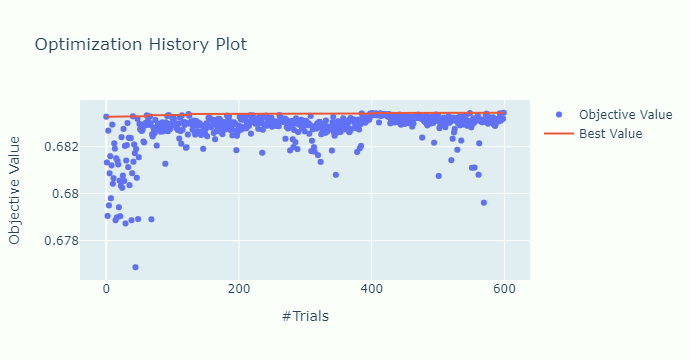

In [17]:
# history
optuna.visualization.plot_optimization_history(study)

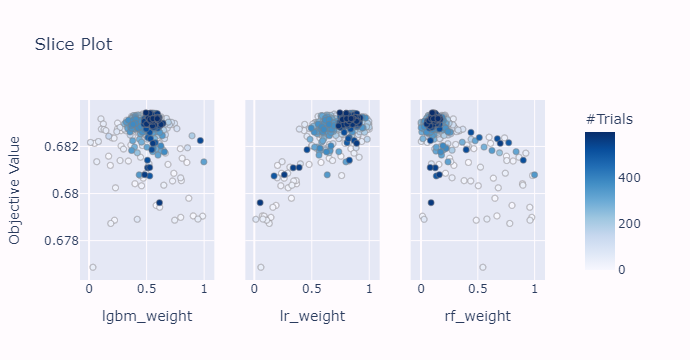

In [18]:
# Visualize individual hyperparameters as slice plot.
optuna.visualization.plot_slice(study)

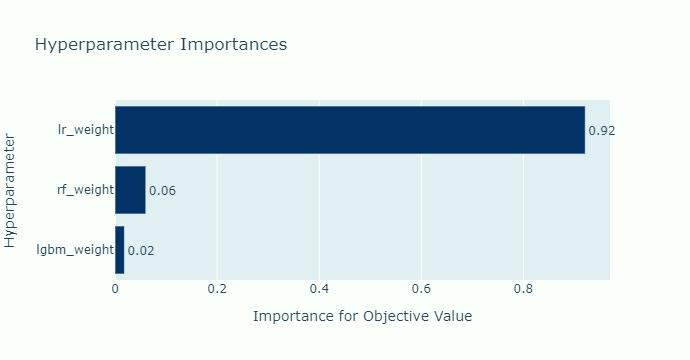

In [19]:
# Visualize parameter importances. 
optuna.visualization.plot_param_importances(study)

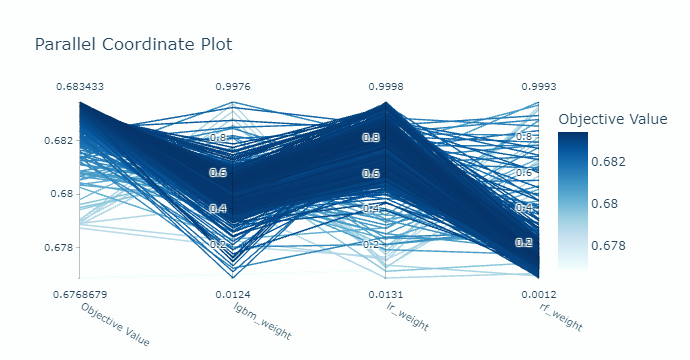

In [20]:
# Space search visualisation
optuna.visualization.plot_parallel_coordinate(study)

## Meilleure solution

In [21]:
# Load best params from last search from file
# study=joblib.load(file_name)
best = study.best_params

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Best trial:
  Value: 0.6834330457197144
  Params: 
    lr_weight: 0.7444383578110437
    rf_weight: 0.09909535803614603
    lgbm_weight: 0.4943384500495088


TRAIN
               precision    recall  f1-score   support

           0       0.96      0.70      0.81    122460
           1       0.17      0.70      0.27     10473

    accuracy                           0.70    132933
   macro avg       0.57      0.70      0.54    132933
weighted avg       0.90      0.70      0.77    132933

 Scores  on train : {'COST': 0.6834330457197144, 'AUC': 0.7461182921286482}
TEST
               precision    recall  f1-score   support

           0       0.96      0.71      0.81     30616
           1       0.16      0.65      0.26      2618

    accuracy                           0.70     33234
   macro avg       0.56      0.68      0.54     33234
weighted avg       0.90      0.70      0.77     33234

 Scores  on test : {'COST': 0.6782699414896728}


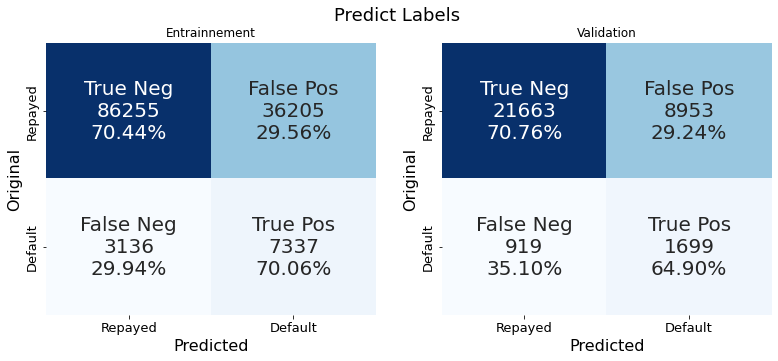

In [22]:
# print best results
# print('Best custom_score = {} for {}'.format(study.best_value,best))

# Initialize params
params = {}

# Logistic regression weight
lr_weight = best['lr_weight']

# Random Forest weight
rf_weight = best['rf_weight']

# LGBM weight
lgbm_weight = best['lgbm_weight']

params['weights'] = [lr_weight, rf_weight, lgbm_weight]
    
# set and fit with best params
voting.set_params(**params)
voting.fit(train, train_true)

# print evaluation summary
evaluate_estimator(voting,
                   train,
                   train_true,
                   test,
                   test_true,
                   SCORER,
                   cost,
                   cv)#,
#                    log=(LOG,run,'Modele/[Optimisation]/'))

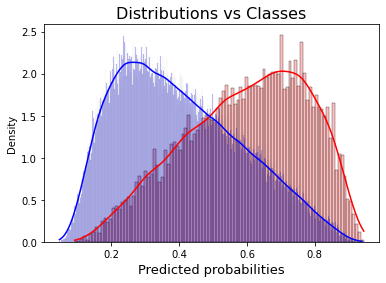

In [23]:
# Distribution of prediction probabilities versus classes
train_predicted_probas = voting.predict_proba(train)
proba_distributions(train_true,train_predicted_probas,(LOG,run,'Modele/[Optimisation]/Train'))

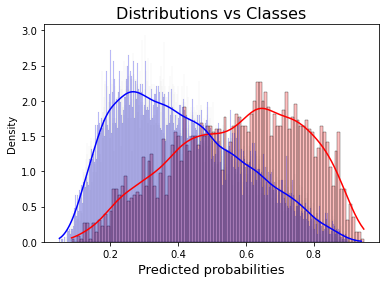

In [24]:
# Distribution of prediction probabilities versus classes
test_predicted_probas = voting.predict_proba(test)
proba_distributions(test_true,test_predicted_probas,(LOG,run,'Modele/[Optimisation]/Test'))

In [25]:
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv_box = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    scores = cross_validate(model,
                            X,
                            y,
                            scoring=SCORER,
                            cv=cv_box,
                            n_jobs=-1,
                            error_score='raise',
                            verbose=2)
    return scores

# # evaluate the model and store results
model = clone(voting)
name = 'voting opt'
scores = evaluate_model(model, train, train_true)
cost_scores = scores['test_COST']
fitting_times = scores['fit_time']
test_score = cost(test_true, voting.predict(test))
print('>%s cv cost score mean: %.4f (\u00B1 %.4f) fitted in %.3f s (\u00B1 %.3f s)' % (name,
                                                                                    cost_scores.mean(),
                                                                                    cost_scores.std(),
                                                                                    fitting_times.mean(),
                                                                                    fitting_times.std()
                                                                                   )
     )
train_cv = (cost_scores)
fit_time_cv = (fitting_times)
cost_test = (test_score)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.0min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


>voting opt cv cost score mean: 0.6834 (± 0.0053) fitted in 56.373 s (± 1.970 s)


In [26]:
Table_ensemble_stats = joblib.load('Results/all_stats.df')
Table_ensemble_stats = Table_ensemble_stats.append({'Model name'   : name,
                                                    'Cost max'     : train_cv.max(),
                                                    'Cost avr'     : train_cv.mean(),
                                                    'Cost min'     : train_cv.min(),
                                                    'Fit time max' : fit_time_cv.max(),
                                                    'Fit time avr' : fit_time_cv.mean(),
                                                    'Fit time min' : fit_time_cv.min(),
                                                    'Cost on test' : cost_test,
                                                   }, ignore_index=True)

Table_ensemble_stats.style.highlight_max()

,Model name,Cost max,Cost avr,Cost min,Fit time max,Fit time avr,Fit time min,Cost on test
0,lr,0.691204,0.681747,0.677224,12.333586,10.981507,9.408714,0.676302
1,rf,0.682291,0.674362,0.670829,24.107776,23.756953,23.225049,0.673935
2,lgbm,0.685214,0.677858,0.672996,21.914827,21.320651,20.082474,0.679327
3,voting,0.688778,0.681816,0.676641,116.180967,101.697165,74.831378,0.676640
4,voting opt,0.692513,0.683433,0.678822,58.099349,56.372617,52.532451,0.678270


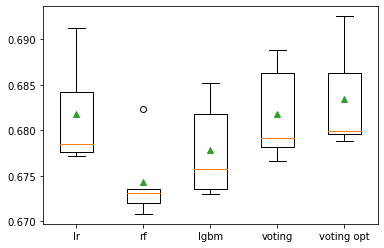

In [27]:
# load results from evaluation in Ensemble Voting out of bag notebook
results_cv = joblib.load('Results/results.array')
# append stats of voting optimized
results_cv.append(train_cv)
# plot model performance for comparison
plt.boxplot(results_cv, labels=Table_ensemble_stats['Model name'], showmeans=True)
plt.show()

In [28]:
joblib.dump(Table_ensemble_stats, 'Results/all_stats_final.df')
joblib.dump(results_cv, 'Results/results_final.array')
if LOG:
    run['Table_ensemble_stats'] = Table_ensemble_stats
    run['Table_ensemble_stats_file'].upload('Results/all_stats_final.df')
    
    

## Sauvegarde du modèle pour dasboard

modèle fitté sur toutes les données disponibles

In [29]:
# Set the filename
save_path = 'Models/'
name= 'voting_optimized_fitted'
file_name = name+'.mod'

# Fit on whole datas
voting.fit(features.drop('TARGET', axis=1), features.TARGET)

# Write on disk
joblib.dump(voting, save_path+file_name, compress=3) #('lzma',3))
if LOG:
    run['Best fitted model on all features jobilb'].upload(File(save_path+file_name))
#     run['Best model fitted on all features pickle'].upload(File.as_pickle(file_named))

In [30]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 4 operations to synchronize with Neptune. Do not kill this process.
Still waiting for the remaining 4 operations (0.00% done). Please wait.
Still waiting for the remaining 4 operations (0.00% done). Please wait.
Still waiting for the remaining 4 operations (0.00% done). Please wait.


All 4 operations synced, thanks for waiting!
